# Scope of the project
This project aims to analyze a dataset regarding weight loss in subjects who followed a diet. We want to understand how the dataset variables interact and influence weight fluctuations, providing insights for researchers and practitioners in nutrition and health. The goal is to build a predictive system for the Final Weight (lbs) of subjects under two conditions:

1. With knowledge of the Basal Metabolic Rate (BMR) at the start of the diet period.

2. Without knowledge of the BMR.

In [1]:
# import all necessaries libraries
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import missingno

# Data Exploration and Quality Analysis
   - Load and explore the dataset, visualizing the results of the exploration.
   - Analyze the quality of the dataset and address any data quality issues.

In [2]:
# import the dataset 
df_weight = pd.read_csv('weight_change_dataset.csv')
df_weight.head(5)

,Participant ID,Age,Gender,BMR (Calories),Daily Calories Consumed,Daily Caloric Surplus/Deficit,Weight Change (lbs),Duration (weeks),Smoking,Physical Activity Level,Sleep Quality,Stress Level,Work Sector,Final Weight (lbs)
0,0,56,M,3102.3,3916.0,NaN,14.57,1,-,Sedentary,Excellent,6,Public,228.6
1,1,46,M,2275.5,3823.0,1547.5,NaN,6,-,Very Active,Excellent,6,Public,167.8
2,2,32,M,2119.4,2785.4,666.0,NaN,7,Yes,Sedentary,Good,3,Self-Employed,144.2
3,3,25,M,2181.3,2587.3,406.0,3.37,8,-,Sedentary,Fair,2,Private,146.3
4,4,38,M,2463.8,3312.8,849.0,3.90,10,-,Lightly Active,Good,1,Unemployed,157.5


In [3]:
df_weight.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Participant ID                 600 non-null    int64  
 1   Age                            600 non-null    int64  
 2   Gender                         600 non-null    object 
 3   BMR (Calories)                 600 non-null    float64
 4   Daily Calories Consumed        544 non-null    float64
 5   Daily Caloric Surplus/Deficit  540 non-null    float64
 6   Weight Change (lbs)            544 non-null    float64
 7   Duration (weeks)               600 non-null    int64  
 8   Smoking                        600 non-null    object 
 9   Physical Activity Level        600 non-null    object 
 10  Sleep Quality                  600 non-null    object 
 11  Stress Level                   600 non-null    int64  
 12  Work Sector                    540 non-null    obj

There are 600 instances in the dataset, indicating that it is a relatively small dataset. We also have missing values in the numerical features 'Daily Calories Consumed,' 'Daily Caloric Surplus/Deficit,' and 'Weight Change,' as well as in the categorical feature 'Work Sector'

In [4]:
df_weight.describe()

,Participant ID,Age,BMR (Calories),Daily Calories Consumed,Daily Caloric Surplus/Deficit,Weight Change (lbs),Duration (weeks),Stress Level,Final Weight (lbs)
count,600.000000,600.000000,600.000000,544.000000,540.000000,544.000000,600.000000,600.000000,600.000000
mean,299.500000,40.633333,2507.488800,3489.047224,981.939611,-2.750533,6.665000,4.716667,168.341300
std,173.349358,26.724256,245.662118,351.436429,250.527087,6.934349,2.315537,1.677621,20.273139
min,0.000000,-17.000000,1566.500000,2030.900000,82.500000,-42.990000,1.000000,1.000000,98.200000
25%,149.750000,32.750000,2343.990000,3279.757500,817.367500,-6.425000,5.000000,4.000000,156.580000
50%,299.500000,38.000000,2515.620000,3530.750000,979.700000,-2.305000,7.000000,5.000000,168.950000
75%,449.250000,43.000000,2674.585000,3742.855000,1142.392500,1.475000,8.000000,6.000000,180.947500
max,599.000000,207.000000,3390.800000,4000.000000,1922.500000,18.140000,12.000000,9.000000,232.500000


 The 'Age' feature shows unrealistic values (e.g., -17, 207), likely errors. The mean BMR is 2507 calories, while average daily caloric intake is 3489, with a wide range suggesting variability in diet. Weight change averages at -2.75 lbs, indicating slight weight loss on average, but with significant individual differences. The average duration of participation is 6.67 weeks, with moderate stress levels (mean 4.72). The final weight varies widely, averaging 168.34 lbs.

In [5]:
# dropping the ID because we don't need it for the modeling
df_weight = df_weight.drop(columns=['Participant ID'])

In [6]:
# counts the different possible outputs of every features
for element in df_weight.columns:
    print(f"unique values of {element}: {df_weight[element].nunique()}")

unique values of Age: 62
unique values of Gender: 3
unique values of BMR (Calories): 592
unique values of Daily Calories Consumed: 436
unique values of Daily Caloric Surplus/Deficit: 532
unique values of Weight Change (lbs): 471
unique values of Duration (weeks): 12
unique values of Smoking: 2
unique values of Physical Activity Level: 4
unique values of Sleep Quality: 5
unique values of Stress Level: 9
unique values of Work Sector: 4
unique values of Final Weight (lbs): 513


<Axes: >

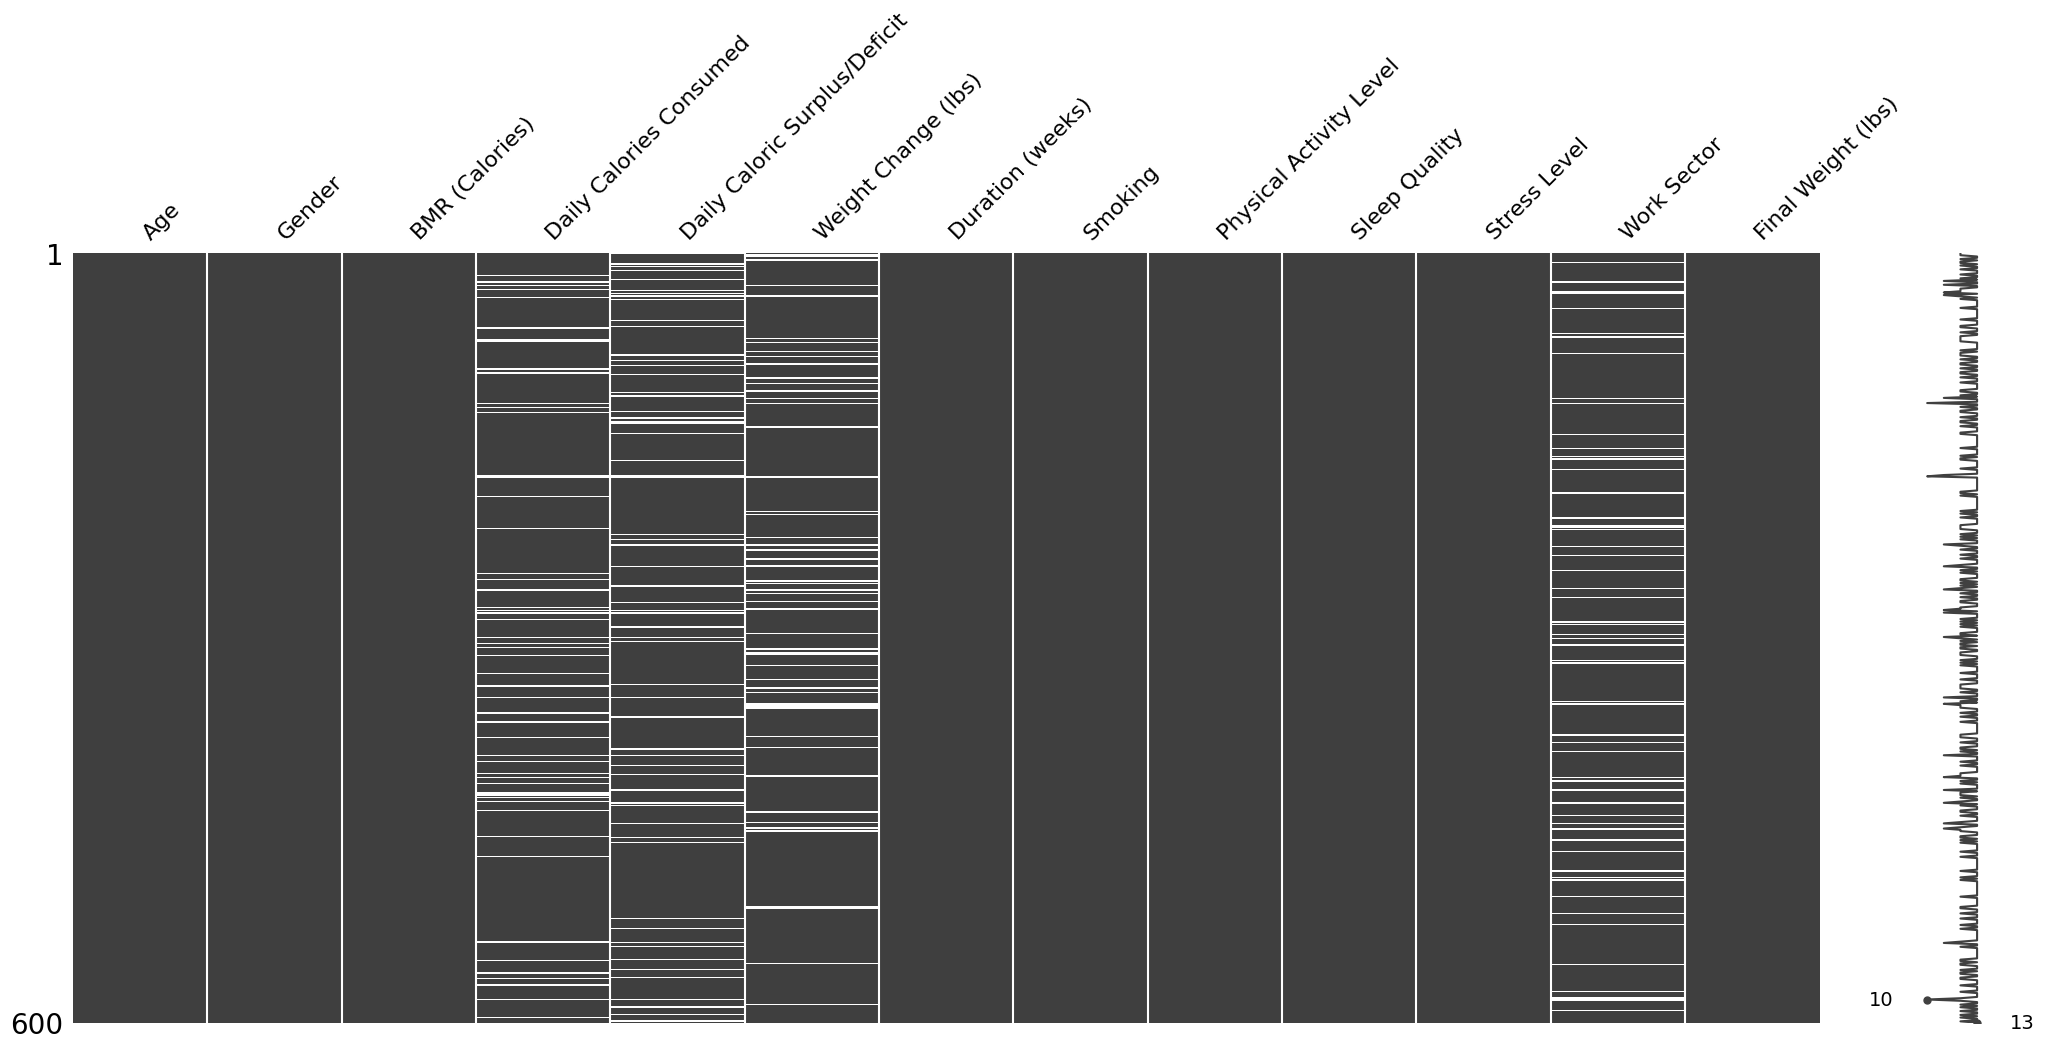

In [7]:
missingno.matrix(df_weight)

From the matrix, it is clear that the only columns with missing values are 'Daily Calories Consumed,' 'Daily Caloric Surplus/Deficit,' and 'Weight Change,' which are continuous variables (float64), and 'Work Sector,' a discrete variable (object). Since the missing values do not exceed a critical threshold, we will retain the data and apply kNN imputation for all affected features instead of removing any data

In [8]:
# handling the missing values
# Check for missing values and display a summary
missing_summary = df_weight.isna().sum()

# Display only columns with missing values
missing_summary = missing_summary[missing_summary > 0]
print("Missing values summary:")
print(missing_summary)


Missing values summary:
Daily Calories Consumed          56
Daily Caloric Surplus/Deficit    60
Weight Change (lbs)              56
Work Sector                      60
dtype: int64


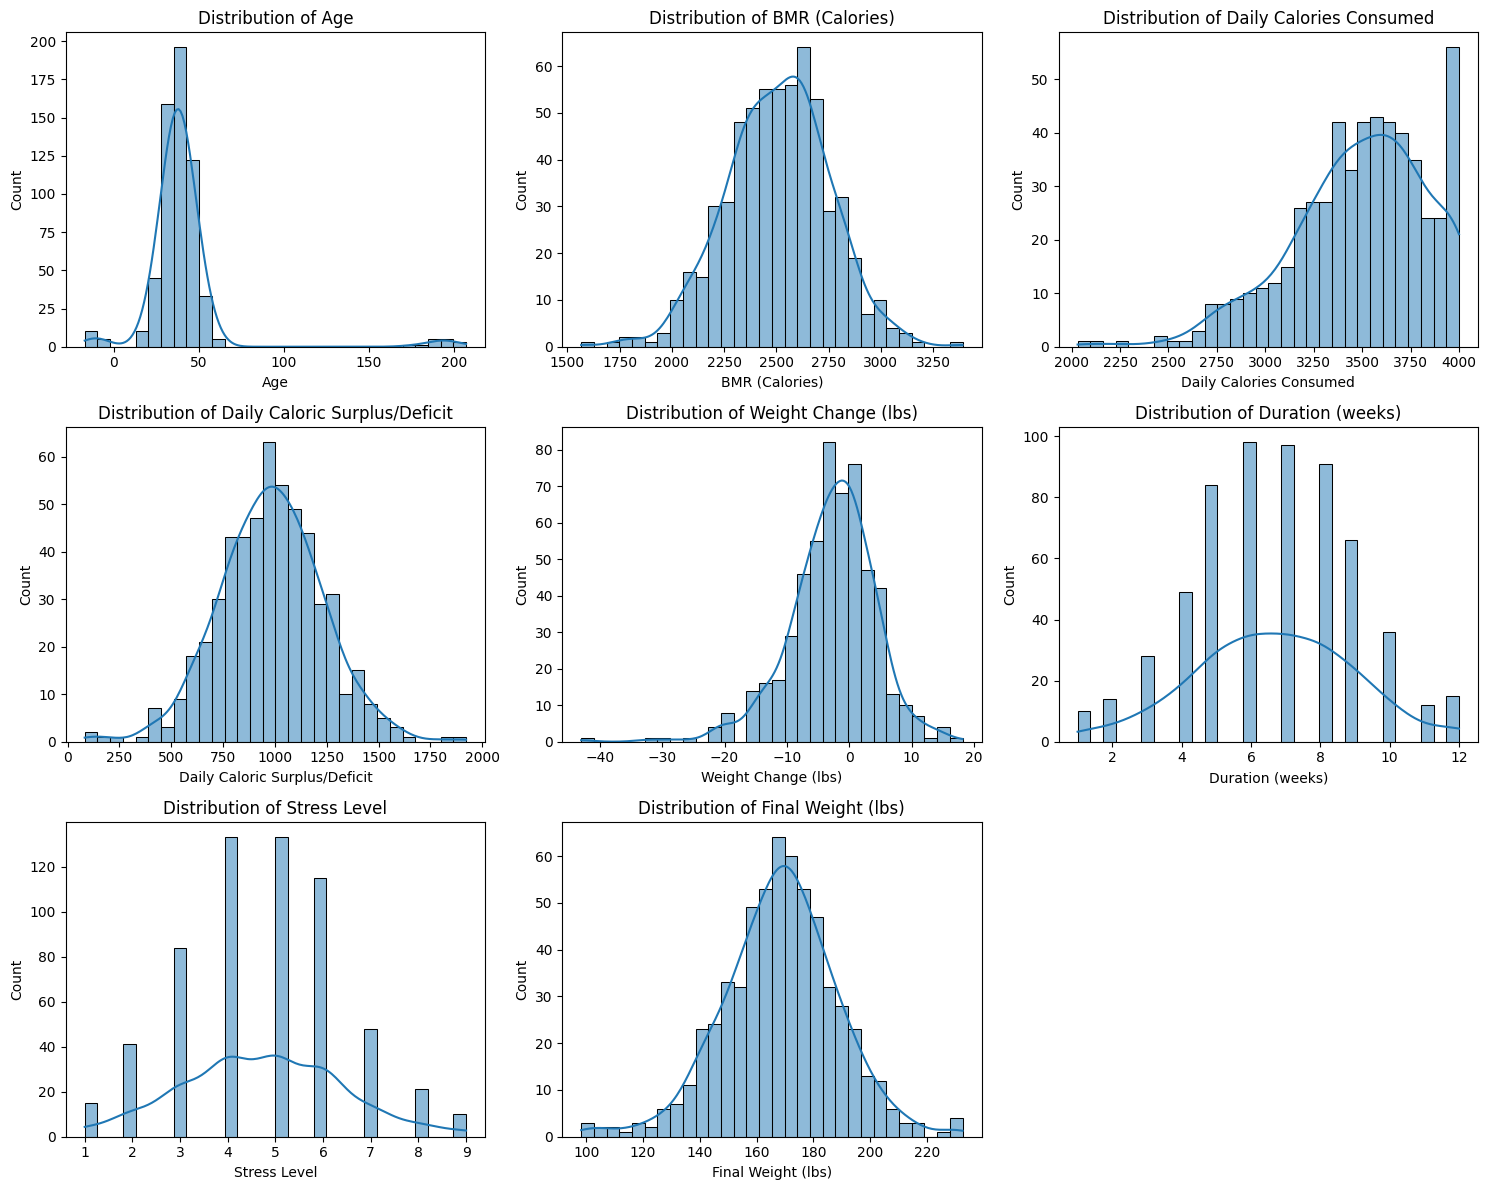

In [9]:
numerical_columns = df_weight.select_dtypes(include=['float64', 'int64']).columns


# Definisce il numero di colonne e righe per la griglia
num_features = len(numerical_columns)
num_cols = 3 # Numero di colonne nella griglia
num_rows = (num_features // num_cols) + (num_features % num_cols > 0)

# Crea una figura con sottotrame
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 4 * num_rows))
axes = axes.flatten()  # Rende gli assi in un array 1D per semplificare l'iterazione

# Plot di ogni feature
for i, col in enumerate(numerical_columns):
    sns.histplot(df_weight[col], kde=True, ax=axes[i], bins=30)
    axes[i].set_title(f'Distribution of {col}')

# Rimuove gli assi non utilizzati
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Aggiusta automaticamente la spaziatura tra i plot
plt.show()

- Firstly, we observe that each distribution has a different scale, so we need to standardize them to ensure proper model performance.
- As noted from df_weight.describe(), the 'Age' feature has impossible values, such as negative ages or values that are unrealistically high.
- The histogram of 'Daily Calories Consumed' is right-skewed; we should transform it for a more symmetrical distribution.
- All other distributions appear reasonable, with credible values and generally bell-shaped distributions.

In [10]:
# Detection with percentiles
# Handling of the outliers of the column 'Age'

# Detection with percentiles
def detection_percentile(data, column):
    upper_lim = data[column].quantile(0.95)
    lower_lim = data[column].quantile(0.05)
    data[column] = np.where((data[column] > upper_lim) | (data[column] < lower_lim), np.nan, data[column])
    return data

# Apply the function and re-assign df_weight
df_weight = detection_percentile(df_weight, 'Age')

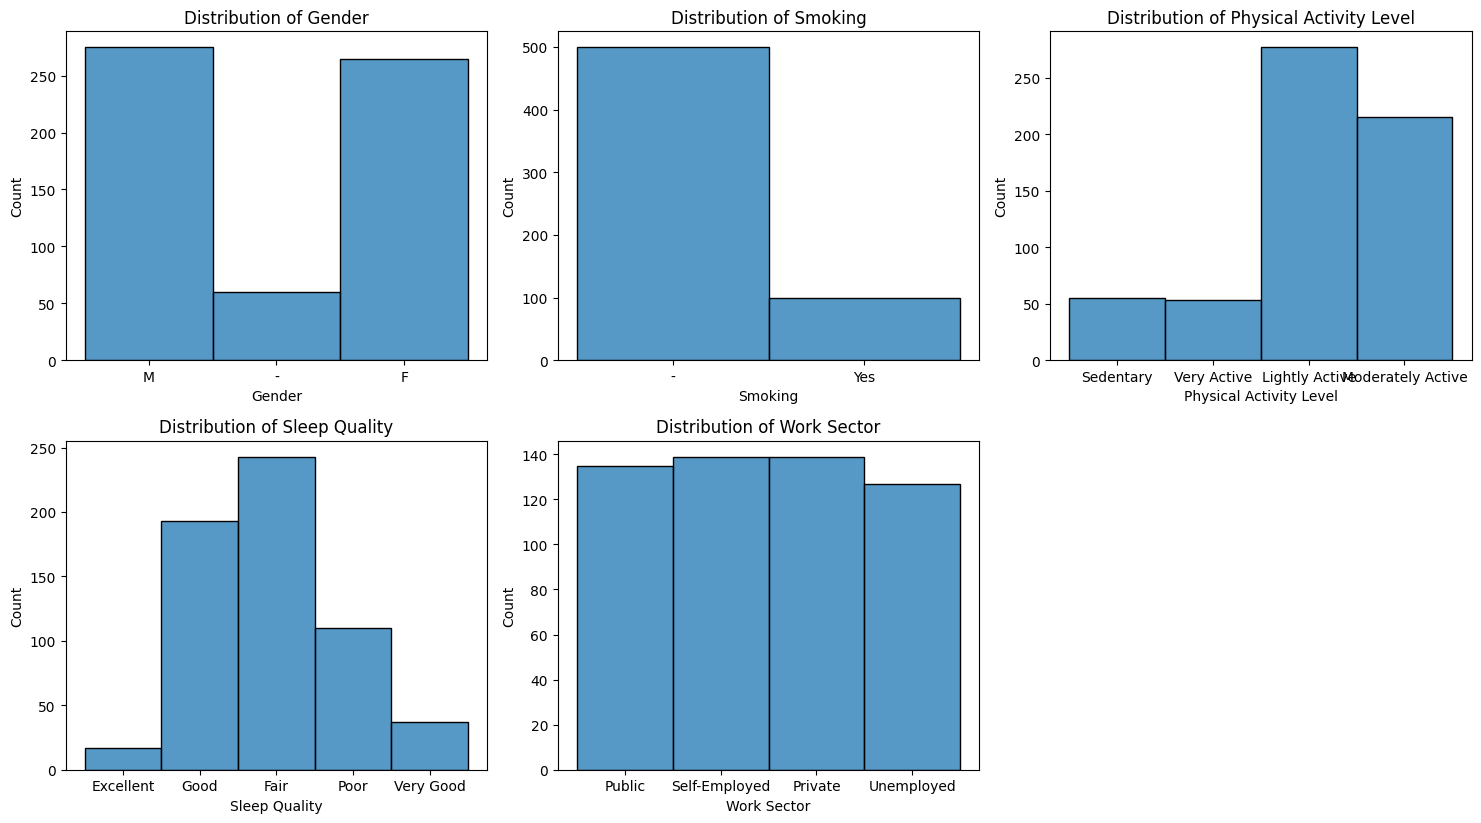

In [11]:
# Plot all the categorical features (type = object)
categorical_columns = df_weight.select_dtypes(include='object').columns
num_features = len(numerical_columns)
num_cols = 3 
num_rows = (num_features // num_cols) + (num_features % num_cols > 0)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 4 * num_rows))
axes = axes.flatten()  

for i, col in enumerate(categorical_columns):
    sns.histplot(x=df_weight[col], ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  
plt.show()

- As we can see, the feature 'Distribution of Gender' should be binary, but it has missing labels in some cases, indicated by the label "-"
- In the 'Smoking' distribution, we should consider the missing label ("-") as 'No'.

In [12]:
# looks for correlations
# Select only numeric columns for correlation calculation
corr_matrix = df_weight.select_dtypes(include=[np.number]).corr()
corr_matrix['Final Weight (lbs)'].sort_values(ascending=False)


Final Weight (lbs)               1.000000
BMR (Calories)                   0.899977
Daily Calories Consumed          0.604635
Weight Change (lbs)              0.011807
Duration (weeks)                -0.001367
Age                             -0.014459
Daily Caloric Surplus/Deficit   -0.047986
Stress Level                    -0.122917
Name: Final Weight (lbs), dtype: float64

We can see that the features 'BMR' and 'Daily Calories Consumed' have both a strong positive correlation with the feature 'Final Weight', let's see the two scatterplots:

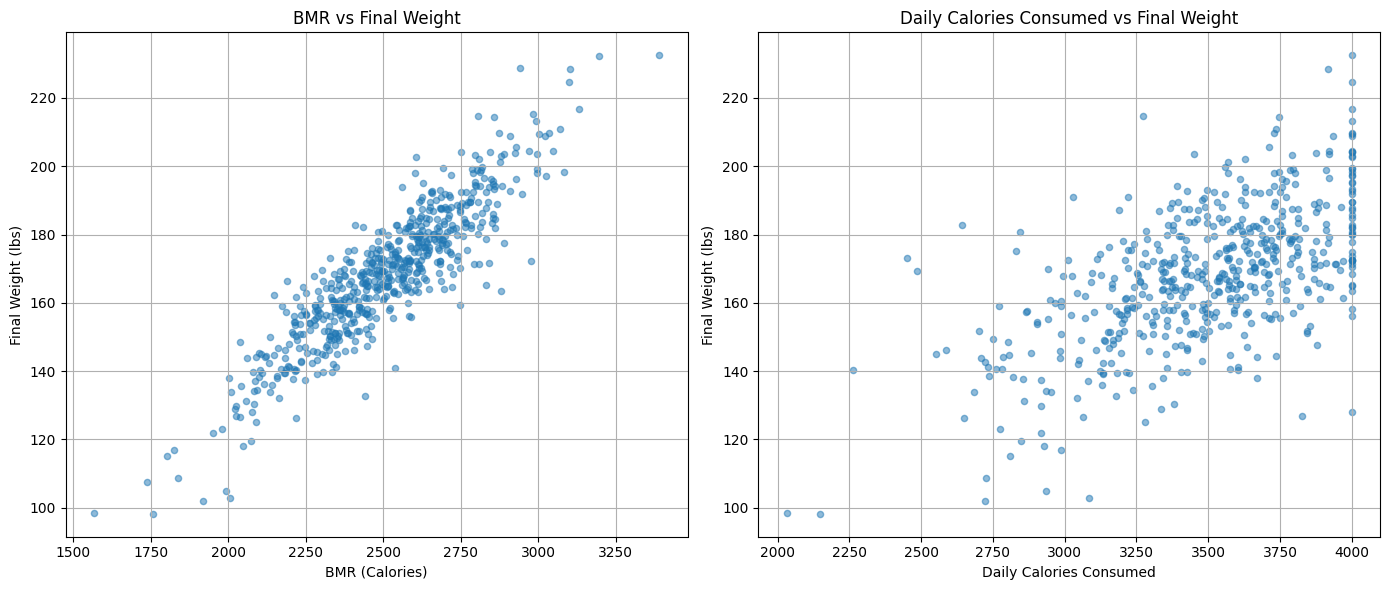

In [13]:
# plot the features with an high correlation 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6)) 

df_weight.plot(kind='scatter', x='BMR (Calories)', y='Final Weight (lbs)', alpha=0.5, grid=True, ax=ax1)
ax1.set_title('BMR vs Final Weight')

# Plot the second scatter plot on ax2
df_weight.plot(kind='scatter', x='Daily Calories Consumed', y='Final Weight (lbs)', alpha=0.5, grid=True, ax=ax2)
ax2.set_title('Daily Calories Consumed vs Final Weight')

plt.tight_layout()  
plt.show()

Based on the scatter plots, we can already say that the features 'BMR (Calories)' and 'Daily Calories Consumed' will likely have a strong impact on predicting 'Final Weight'.

In [14]:
# handling the duplicates
duplicates = df_weight.duplicated().sum()
print(f'In the dataset there are {duplicates} data points duplicated')

In the dataset there are 0 data points duplicated


# Dataset Preparation for Linear Regression
   a. Verify the distribution of the numerical feature values.

   b. Perform feature transformations for numerical variables if necessary, and justify your choices.

   c. Encode categorical variables if necessary, and justify your choices.
   
   d. Consider reducing the dataset's dimensionality. Use at least one univariate method, an iterative method, and a model-based method to determine important features. Verify if different methodologies select the same features.
   
   e. Define a reduced dataset (`dataset_reduced`) based on the above analysis for use in the supervised learning task.


## a. Verify the distribution of the numerical feature values

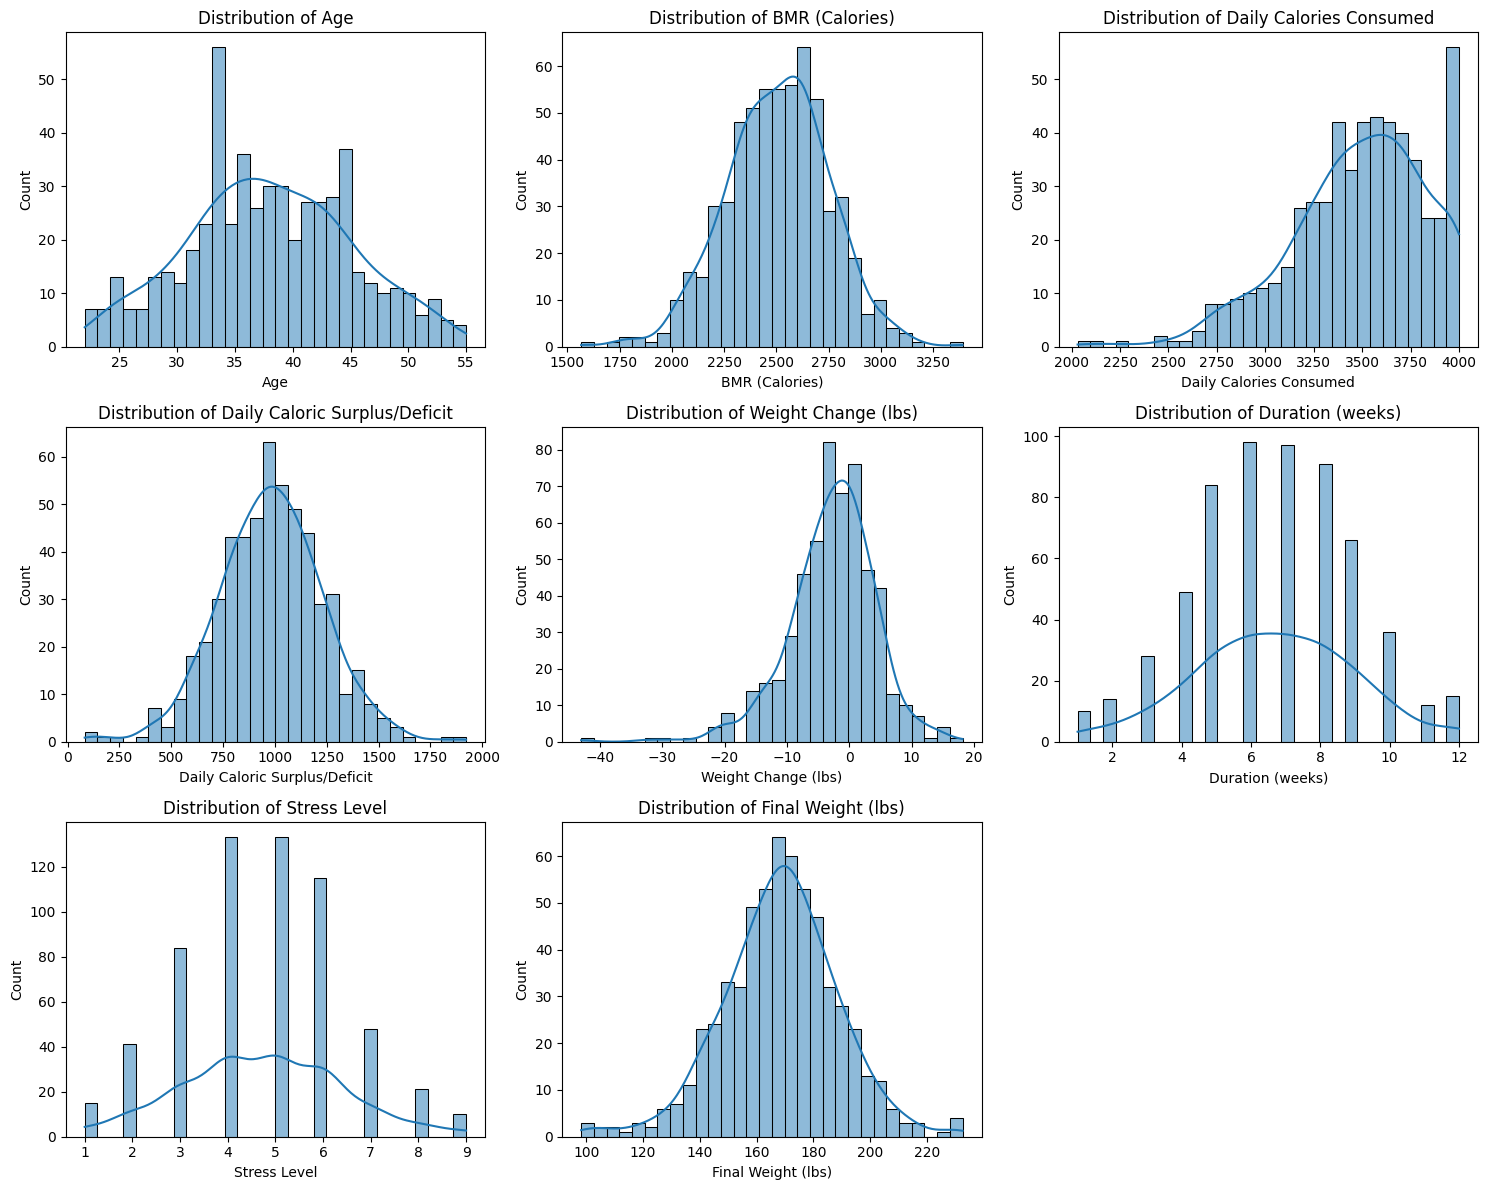

In [15]:
# Function to visualize the distribution of all numerical features
numerical_columns = df_weight.select_dtypes(include=['float64', 'int64']).columns

num_features = len(numerical_columns)
num_cols = 3 
num_rows = (num_features // num_cols) + (num_features % num_cols > 0)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 4 * num_rows))
axes = axes.flatten()  

for i, col in enumerate(numerical_columns):
    sns.histplot(df_weight[col], kde=True, ax=axes[i], bins=30)
    axes[i].set_title(f'Distribution of {col}')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  
plt.show()

### split the dataset 

In [16]:
from sklearn.model_selection import train_test_split

X = df_weight.drop(columns=['Final Weight (lbs)'])

# Split the dataset and verify that the shapes match
y = df_weight['Final Weight (lbs)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape)


(420, 12) (420,)


Using 30% for testing allows us to assess the model’s generalization ability effectively without sacrificing too much data from training.

## b. Perform feature transformation

As mentioned before, all the numerical features appear to follow a roughly normal distribution, except for 'Daily Calories Consumed,' which is left-skewed. Therefore, we can apply a transformation to make it more symmetrical.

In [17]:

# Apply a mirrored log transformation to 'Daily Calories Consumed' to reduce skewness
max_value = X_train['Daily Calories Consumed'].max() + 1

X_train['Daily Calories Consumed Original'] = X_train['Daily Calories Consumed']

X_train['Daily Calories Consumed'] = np.log(max_value - X_train['Daily Calories Consumed'])

X_test['Daily Calories Consumed'] = np.log(max_value - X_test['Daily Calories Consumed'])



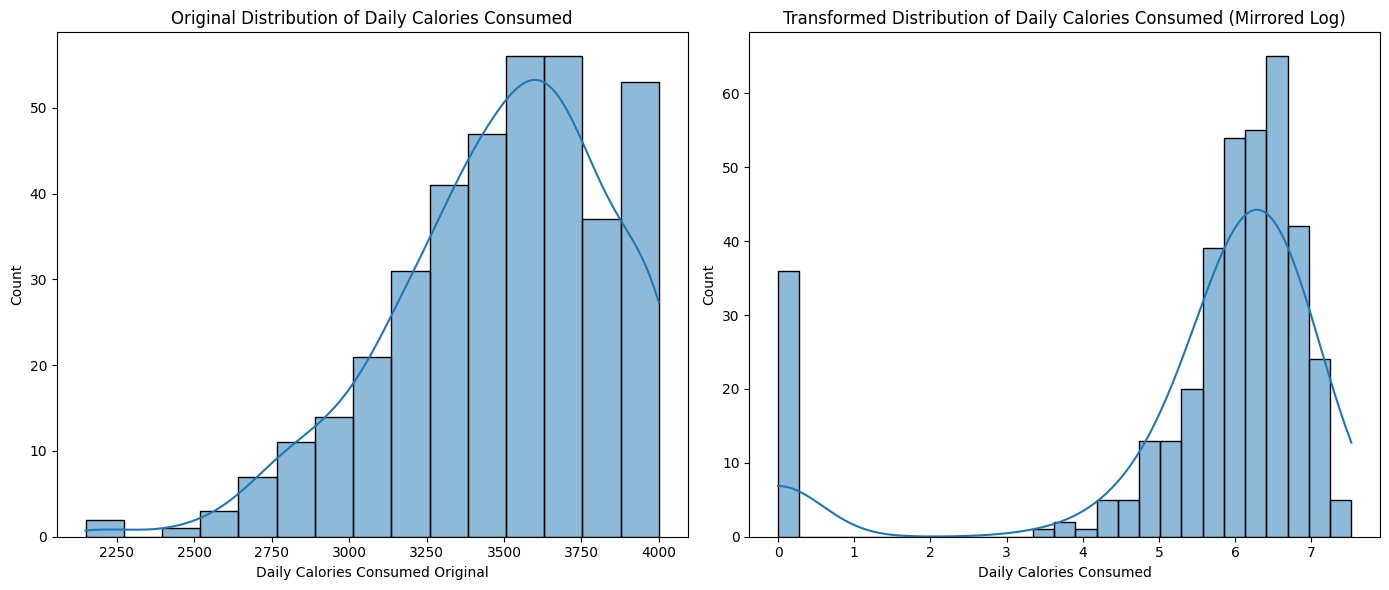

In [18]:
# show the transformed distribution and drop the Original column 

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(X_train['Daily Calories Consumed Original'], kde=True, ax=axes[0])
axes[0].set_title('Original Distribution of Daily Calories Consumed')

sns.histplot(X_train['Daily Calories Consumed'], kde=True, ax=axes[1])
axes[1].set_title('Transformed Distribution of Daily Calories Consumed (Mirrored Log)')

plt.tight_layout()
plt.show()

X_train.drop(columns=['Daily Calories Consumed Original'], inplace=True)

after the transformation I keep all values, even if some are far from the ditribution, as I consider them to be meaningful and plausible data from the original distribution

## c. Encode categorical variables


As noted in the distribution and description of the categorical features, we will handle each feature as follows:
- For 'Smoking,' missing values are already treated as 'No,' and we'll apply one-hot encoding.
- For 'Gender,' missing values will be capped as NaN, then one-hot encoded, and later imputed using kNN.
- For 'Sleep Quality,' we’ll apply ordinal encoding.
- For 'Physical Activity Level,' we’ll use a replacement ordinal encoding.
- For 'Work Sector,' we’ll apply one-hot encoding.


In [19]:
#create a copy before all the feature selection and transformation
df_train_copy = X_train.copy(deep=True) 
df_test_copy = X_test.copy(deep=True)

### encoding

In [20]:
from sklearn.preprocessing import OneHotEncoder

# Step 1: Replace placeholders in 'Gender' and 'Smoking' with NaN or specific values
X_train['Gender'].replace('-', np.nan, inplace=True)
X_train['Smoking'].replace('-', 'No', inplace=True)

X_test['Gender'].replace('-', np.nan, inplace=True)
X_test['Smoking'].replace('-', 'No', inplace=True)

# Step 2: One-Hot Encoding for nominal categorical features: 'Smoking', 'Gender', 'Work Sector'
encoder = OneHotEncoder(sparse_output=False, drop=None, handle_unknown='ignore')
X_train_encoded = encoder.fit_transform(X_train[['Smoking', 'Gender', 'Work Sector']])
X_test_encoded = encoder.transform(X_test[['Smoking', 'Gender', 'Work Sector']])

feature_names = encoder.get_feature_names_out(['Smoking', 'Gender', 'Work Sector'])

# Convert encoded output to DataFrame with named columns
X_train_encoded = pd.DataFrame(X_train_encoded, columns=feature_names, index=X_train.index)
X_test_encoded = pd.DataFrame(X_test_encoded, columns=feature_names, index=X_test.index)

# Concatenate 
X_train = pd.concat([X_train, X_train_encoded], axis=1)
X_test = pd.concat([X_test, X_test_encoded], axis=1)

# Drop the original columns after encoding
X_train.drop(columns=['Smoking', 'Gender', 'Work Sector'], inplace=True)
X_test.drop(columns=['Smoking', 'Gender', 'Work Sector'], inplace=True)


C:\Users\ms\AppData\Local\Temp\ipykernel_21280\1022553409.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train['Gender'].replace('-', np.nan, inplace=True)
C:\Users\ms\AppData\Local\Temp\ipykernel_21280\1022553409.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

In [21]:
# Step 3: Ordinal Encoding for ordered categorical features
sleep_quality_mapping = {
    'Poor' : 0,
    'Fair': 1,
    'Good': 2,
    'Very Good': 3,
    'Excellent': 4

}
physical_activity_mapping = {
    'Sedentary': 0,
    'Lightly Active': 1,
    'Moderately Active': 2,
    'Very Active': 3
}

# Apply ordinal encoding mappings
X_train['Sleep Quality'].replace(sleep_quality_mapping, inplace=True)
X_test['Sleep Quality'].replace(sleep_quality_mapping, inplace=True)

X_train['Physical Activity Level'].replace(physical_activity_mapping, inplace=True)
X_test['Physical Activity Level'].replace(physical_activity_mapping, inplace=True)

C:\Users\ms\AppData\Local\Temp\ipykernel_21280\1755131672.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train['Sleep Quality'].replace(sleep_quality_mapping, inplace=True)
C:\Users\ms\AppData\Local\Temp\ipykernel_21280\1755131672.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train[

- One-Hot Encoding for Nominal Features:
    We applied one-hot encoding to 'Smoking,' 'Gender,' and 'Work Sector' since these categories have no inherent order. This creates binary columns for each category, allowing the model to treat them as independent.

- Ordinal Encoding for Ordered Features:
    'Sleep Quality' and 'Physical Activity Level' were encoded ordinally because they have a natural order.
    Sleep Quality: Mapped from 'Poor' (0) to 'Excellent' (4).
    Physical Activity Level: Mapped from 'Sedentary' (0) to 'Very Active' (3).
    
This encoding captures both independent and ranked relationships, ensuring that the model interprets each feature correctly.

### scaling

In [22]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Instantiate the scalers
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()
robust_scaler = RobustScaler()

# Columns for each scaling method based on the distribution analysis
standard_scaling_columns = ['BMR (Calories)', 'Daily Caloric Surplus/Deficit', 'Weight Change (lbs)', 'Age', 'Stress Level','Duration (weeks)']
minmax_scaling_columns = ['Daily Calories Consumed',  'Physical Activity Level', 'Sleep Quality']


# Apply Standard Scaling
X_train[standard_scaling_columns] = standard_scaler.fit_transform(X_train[standard_scaling_columns])
X_test[standard_scaling_columns] = standard_scaler.transform(X_test[standard_scaling_columns])

# Apply Min-Max Scaling
X_train[minmax_scaling_columns] = minmax_scaler.fit_transform(X_train[minmax_scaling_columns])
X_test[minmax_scaling_columns] = minmax_scaler.transform(X_test[minmax_scaling_columns])


Standard Scaling: Applied to 'BMR (Calories)', 'Daily Caloric Surplus/Deficit', 'Weight Change (lbs)', 'Age', 'Stress Level', and 'Duration (weeks)' since they are approximately normally distributed. This centers them around 0 with unit variance.

Min-Max Scaling: Used for 'Daily Calories Consumed', 'Physical Activity Level', and 'Sleep Quality' to fit values within a 0-1 range, suitable for features with non-normal distributions.

This approach ensures each feature is scaled appropriately based on its distribution that I have verified before.

### Imputation missing values

In [23]:
from sklearn.impute import KNNImputer

# Initialize KNN Imputer
imputer = KNNImputer(n_neighbors=5)

X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Convert the imputed arrays back to DataFrames with original column names
X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns, index=X_train.index)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test.columns, index=X_test.index)

# Drop the 'Work Sector_nan' column if confirmed unnecessary
X_train_imputed.drop(columns=['Work Sector_nan'], inplace=True)
X_test_imputed.drop(columns=['Work Sector_nan'], inplace=True)

# Drop the 'Gender' column if confirmed unnecessary
X_train_imputed.drop(columns=['Gender_nan'], inplace=True)
X_test_imputed.drop(columns=['Gender_nan'], inplace=True)

# Verify the result
print("Missing values after KNN Imputation on X_train:")
print(X_train_imputed.isna().sum())

X_train = X_train_imputed
X_test = X_test_imputed

Missing values after KNN Imputation on X_train:
Age                              0
BMR (Calories)                   0
Daily Calories Consumed          0
Daily Caloric Surplus/Deficit    0
Weight Change (lbs)              0
Duration (weeks)                 0
Physical Activity Level          0
Sleep Quality                    0
Stress Level                     0
Smoking_No                       0
Smoking_Yes                      0
Gender_F                         0
Gender_M                         0
Work Sector_Private              0
Work Sector_Public               0
Work Sector_Self-Employed        0
Work Sector_Unemployed           0
dtype: int64


KNN Imputer: KNNImputer with 5 neighbors is used to fill missing values based on the values of similar instances, preserving feature relationships for more accurate imputations. KNN imputation is chosen because it uses patterns in the existing data to fill in missing values. By leveraging the values of the k-nearest neighbors (5 in this case), it imputes missing values based on similar data points, which helps maintain relationships between features

<Axes: >

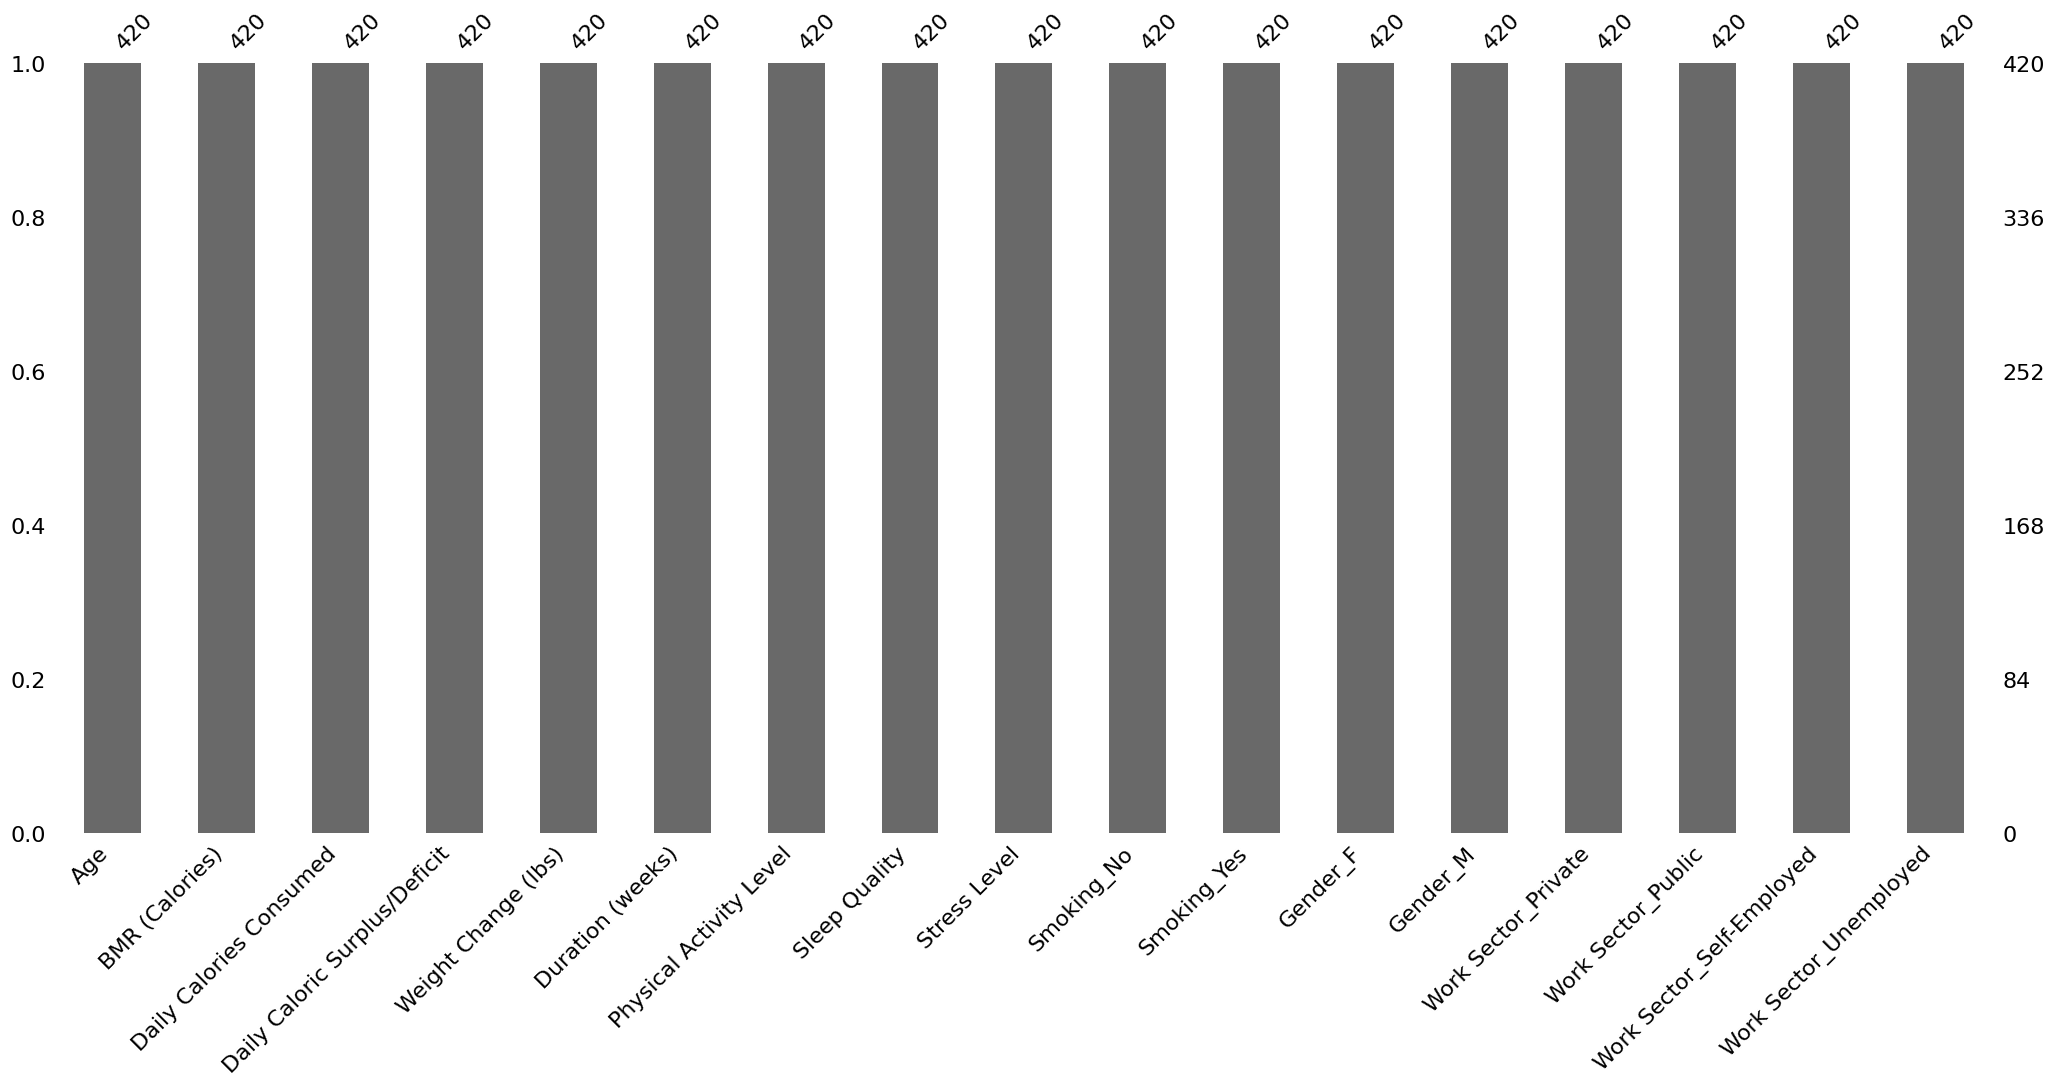

In [24]:
missingno.bar(X_train)

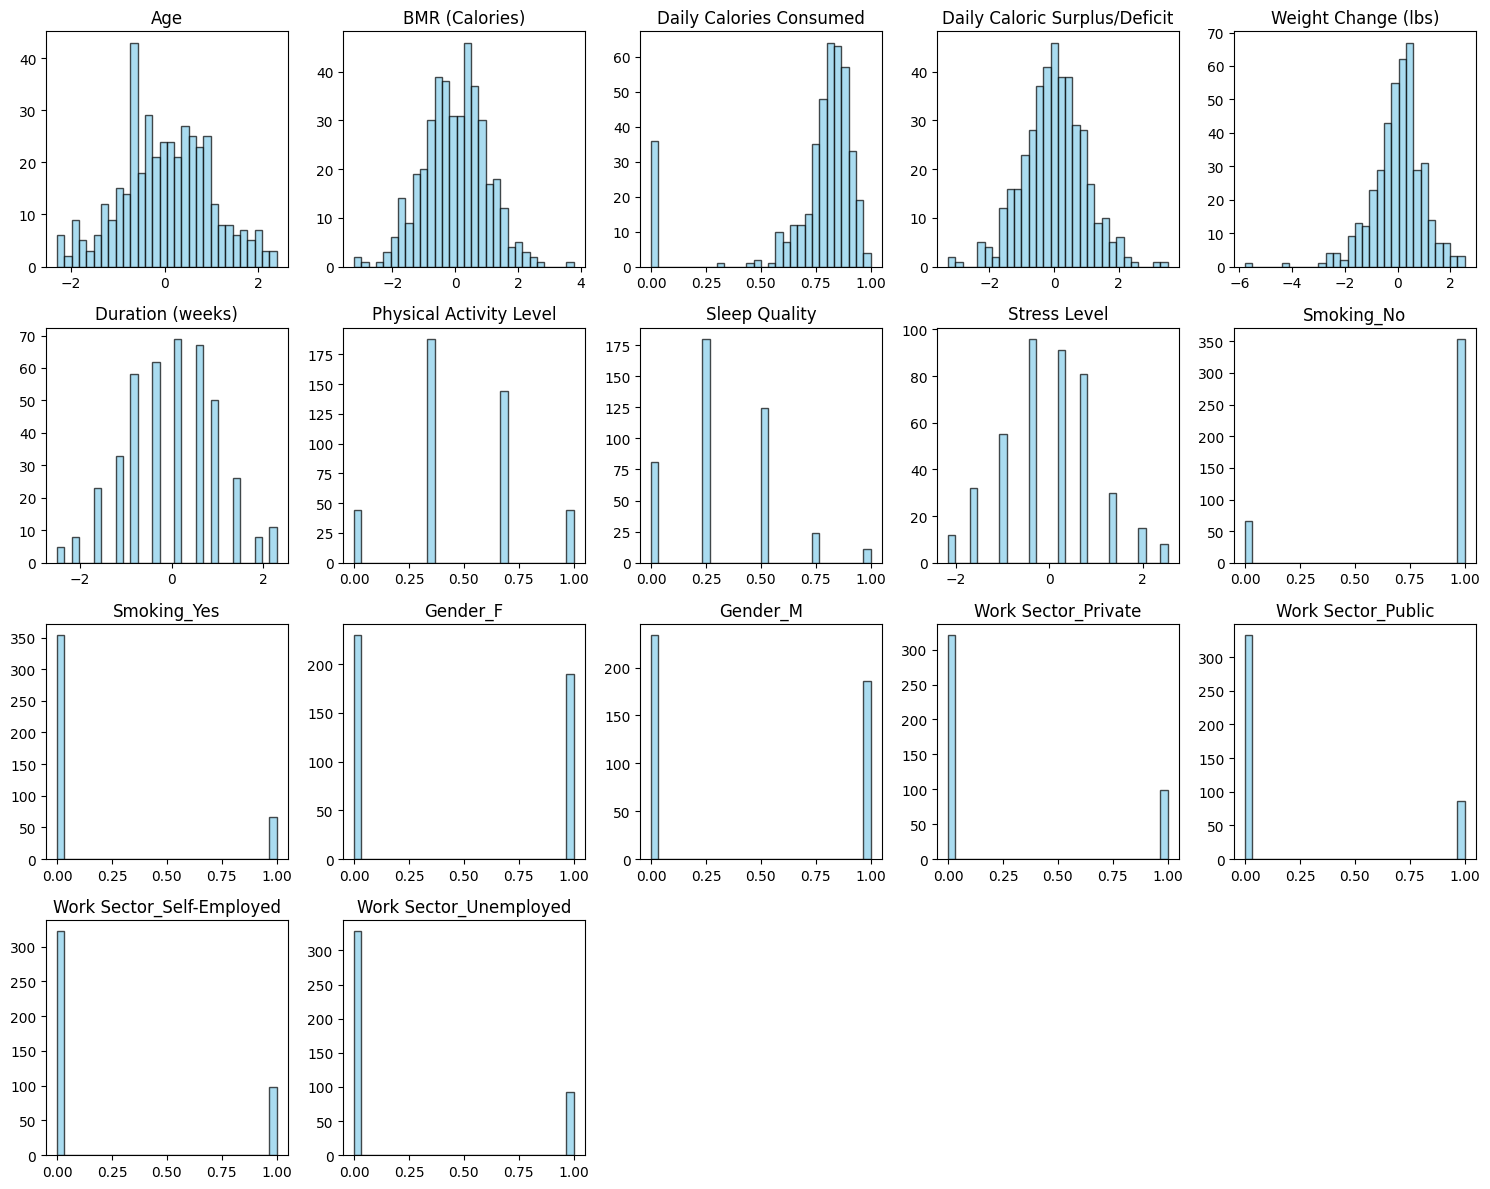

In [25]:
import matplotlib.pyplot as plt

# Plot histograms for each feature
features = X_train.columns  
plt.figure(figsize=(15, 12))

for i, feature in enumerate(features):
    plt.subplot(4, 5, i+1)  
    plt.hist(X_train[feature], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title(feature)
    plt.tight_layout()

plt.show()


## d. Reducing the dataset dimensionality

univariate feature selection with an ANOVA F-test 

In [26]:
from sklearn.feature_selection import f_regression
import pandas as pd

# Perform ANOVA F-test and get F-values and p-values
f_values, p_values = f_regression(X_train, y_train)

# Create DataFrame to store feature names and p-values
anova_results = pd.DataFrame({'Feature': X_train.columns, 'F-value': f_values, 'p-value': p_values})

# Set significance threshold (e.g., 0.05)
significance_threshold = 0.05

# Select features with p-values below the threshold
anova_selected_features = anova_results[anova_results['p-value'] < significance_threshold]['Feature'].tolist()
print("ANOVA-selected features:", anova_selected_features)

ANOVA-selected features: ['BMR (Calories)', 'Daily Calories Consumed', 'Sleep Quality', 'Stress Level']


Recursive Feature Elimination (RFE)

In [27]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

# Define the number of features to select (in this case I chose 50%)
n_features_to_select = X_train.shape[1] // 2

# Apply RFE with RandomForestRegressor
select_rfe = RFE(RandomForestRegressor(n_estimators=100, random_state=42), n_features_to_select=n_features_to_select)
select_rfe.fit(X_train, y_train)

# Get selected feature mask and names
mask_rfe = select_rfe.get_support()
rfe_selected_features = X_train.columns[mask_rfe]
print("RFE-selected features:", rfe_selected_features)

RFE-selected features: Index(['Age', 'BMR (Calories)', 'Daily Calories Consumed',
       'Daily Caloric Surplus/Deficit', 'Weight Change (lbs)',
       'Duration (weeks)', 'Sleep Quality', 'Stress Level'],
      dtype='object')


Model based feature selection

In [28]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor

# Apply SelectFromModel with RandomForestRegressor and median threshold
select_rf = SelectFromModel(RandomForestRegressor(n_estimators=100, random_state=42), threshold="median")
select_rf.fit(X_train, y_train)

# Get selected feature mask and names
mask_rf = select_rf.get_support()
rf_selected_features = X_train.columns[mask_rf]
print("Model-based Random Forest selected features:", rf_selected_features)


Model-based Random Forest selected features: Index(['Age', 'BMR (Calories)', 'Daily Calories Consumed',
       'Daily Caloric Surplus/Deficit', 'Weight Change (lbs)',
       'Duration (weeks)', 'Physical Activity Level', 'Sleep Quality',
       'Stress Level'],
      dtype='object')


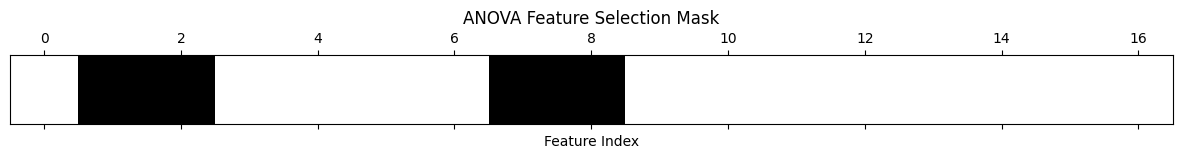

<Figure size 1500x200 with 0 Axes>

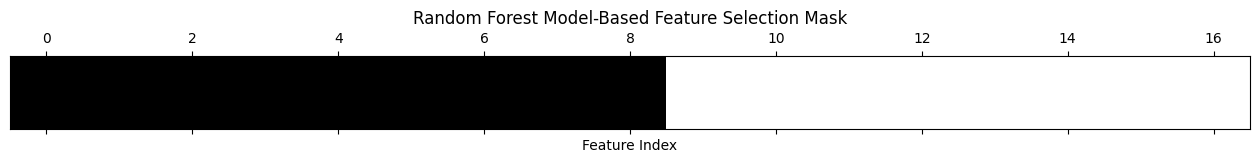

<Figure size 1500x200 with 0 Axes>

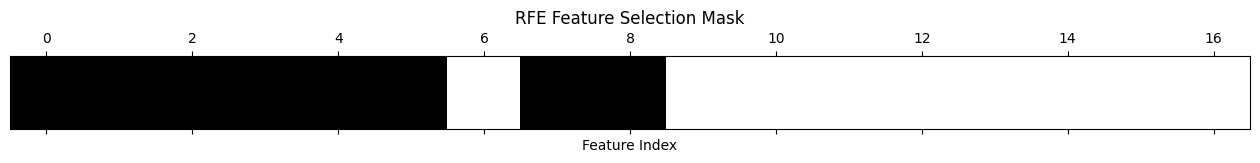

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# ANOVA selection mask
mask_anova = np.array([feature in anova_selected_features for feature in X_train.columns])

plt.figure(figsize=(15, 2))
plt.matshow(mask_anova.reshape(1, -1), cmap='gray_r', fignum=1)
plt.title("ANOVA Feature Selection Mask")
plt.xlabel("Feature Index")
plt.yticks([])  
plt.show()

# Random Forest model-based mask
plt.figure(figsize=(15, 2))
plt.matshow(mask_rf.reshape(1, -1), cmap='gray_r', fignum=2)
plt.title("Random Forest Model-Based Feature Selection Mask")
plt.xlabel("Feature Index")
plt.yticks([])
plt.show()

# RFE selection mask
plt.figure(figsize=(15, 2))
plt.matshow(mask_rfe.reshape(1, -1), cmap='gray_r', fignum=3)
plt.title("RFE Feature Selection Mask")
plt.xlabel("Feature Index")
plt.yticks([])
plt.show()



it is noticeable that RFE and model based feature selection have chosen almost the same features

In [30]:
# Convert selected features to sets
anova_set = set(anova_selected_features)
rf_set = set(rf_selected_features)
rfe_set = set(rfe_selected_features)

# Find common features across all three methods
common_features = anova_set & rf_set & rfe_set
print("Common features selected by all methods:", common_features)

# Find combined features selected by any method
combined_features = anova_set | rf_set | rfe_set
print("Combined features selected by any method:", combined_features)


Common features selected by all methods: {'Daily Calories Consumed', 'Sleep Quality', 'Stress Level', 'BMR (Calories)'}
Combined features selected by any method: {'Daily Calories Consumed', 'Sleep Quality', 'Daily Caloric Surplus/Deficit', 'Stress Level', 'Physical Activity Level', 'Age', 'BMR (Calories)', 'Weight Change (lbs)', 'Duration (weeks)'}


## e. create a reduced dataset


In [31]:
# Create dataset using only common features across methods
dataset_reduced_common = X_train[list(common_features)]
print("Shape of dataset with common features:", dataset_reduced_common.shape)

# Create dataset using combined features from any method
dataset_reduced_combined = X_train[list(combined_features)]
print("Shape of dataset with combined features:", dataset_reduced_combined.shape)

Shape of dataset with common features: (420, 4)
Shape of dataset with combined features: (420, 9)


In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
import numpy as np

# Train model on full dataset (all features)
model_full = RandomForestRegressor(n_estimators=100, random_state=42)
model_full.fit(X_train, y_train)
y_pred_full = model_full.predict(X_test)

# Calculate RMSE on full dataset
rmse_full = root_mean_squared_error(y_test, y_pred_full)
print("RMSE on full dataset:", rmse_full)

RMSE on full dataset: 8.405082704385219


In [33]:
# Train model on reduced dataset with common features
model_reduced_common = RandomForestRegressor(n_estimators=100, random_state=42)
model_reduced_common.fit(dataset_reduced_common, y_train)

# Test on reduced dataset with common features
dataset_reduced_test_common = X_test[list(common_features)]
y_pred_reduced_common = model_reduced_common.predict(dataset_reduced_test_common)

# Calculate RMSE on reduced dataset with common features
rmse_reduced_common = root_mean_squared_error(y_test, y_pred_reduced_common)
print("RMSE on reduced dataset (common features):", rmse_reduced_common)

RMSE on reduced dataset (common features): 9.286847759143027


In [34]:
# Train model on reduced dataset with combined features
model_reduced_combined = RandomForestRegressor(n_estimators=100, random_state=42)
model_reduced_combined.fit(dataset_reduced_combined, y_train)

# Test on reduced dataset with combined features
dataset_reduced_test_combined = X_test[list(combined_features)]
y_pred_reduced_combined = model_reduced_combined.predict(dataset_reduced_test_combined)

# Calculate RMSE on reduced dataset with combined features
rmse_reduced_combined = root_mean_squared_error(y_test, y_pred_reduced_combined)
print("RMSE on reduced dataset (combined features):", rmse_reduced_combined)

RMSE on reduced dataset (combined features): 8.42034595427448


from the values obtained, I decided to continue with the dataset_reduced_combined which includes the combined features because it reduced the features but at the same time kept a similar RMSE, whereas the dataset_reduced_common reduced the features but increased the RMSE

# Building a Linear Regression Model
   - Build a supervised Linear Regression model to predict the Final Weight (lbs) under the two specified conditions.
   - Implement the following approaches:
   
     a. **Sklearn Linear Regression**: Use the sklearn implementation.

     b. **Batch Gradient Descent**: Implement a batch gradient descent (not using sklearn).
       - Identify the best learning rate \( \eta \) and appropriate number of iterations for model convergence.

     c. **Mini-Batch Gradient Descent**: Implement mini-batch gradient descent (not using sklearn) with a batch size of up to 128 samples (use powers of 2).
       - Identify the best learning rate \( \eta \) and appropriate number of iterations for model convergence.

     d. **Dataset Augmentation**: Add interaction or polynomial features to create `dataset_augmented` and train a new linear regression model using batch gradient descent.
       - Identify the best learning rate \( \eta \) and appropriate number of iterations for model convergence.

     e. **Compare Learning Curves**: Compare the learning curves of the gradient descent approaches above, commenting on the learning procedures and generalization performance.

     f. **Lasso Regularization**: Train a linear regression model with Lasso regularization using `dataset_augmented`, and analyze the feature importance with different values of \( \alpha \). Plot the model performance for various \( \alpha \) values.
     
     g. **Ridge Regression**: Train a Ridge regression model with `dataset_augmented`, optimizing the regularization coefficient \( \alpha \) to achieve the best generalization performance.

### Build the supervised model under the two conditions:
- condition 1: knowing BMR 
- condition 2: not knowing BMR

In [35]:
# Target remains the same
y_train_reduced = y_train  
y_test_reduced = y_test

# 1. Prepare reduced datasets with BMR for the training and test sets
X_train_reduced_with_bmr = dataset_reduced_combined.copy()  # Including BMR
X_test_reduced_with_bmr = X_test[dataset_reduced_combined.columns]  

# 2. Prepare reduced datasets without BMR for the training and test sets
# Drop 'BMR (Calories)' if it is present in the columns
X_train_reduced_without_bmr = X_train_reduced_with_bmr.drop(columns=['BMR (Calories)'], errors='ignore')
X_test_reduced_without_bmr = X_test_reduced_with_bmr.drop(columns=['BMR (Calories)'], errors='ignore')

# Verify shapes and column consistency
print("y_train_reduced shape:", y_train_reduced.shape)
print("y_test_reduced shape:", y_test_reduced.shape)
print("Training set with BMR shape:", X_train_reduced_with_bmr.shape)
print("Training set without BMR shape:", X_train_reduced_without_bmr.shape)
print("Test set with BMR shape:", X_test_reduced_with_bmr.shape)
print("Test set without BMR shape:", X_test_reduced_without_bmr.shape)

# Verify column alignment (optional)
print("Training columns with BMR:", X_train_reduced_with_bmr.columns)
print("Training columns without BMR:", X_train_reduced_without_bmr.columns)
print("Test columns with BMR:", X_test_reduced_with_bmr.columns)
print("Test columns without BMR:", X_test_reduced_without_bmr.columns)


y_train_reduced shape: (420,)
y_test_reduced shape: (180,)
Training set with BMR shape: (420, 9)
Training set without BMR shape: (420, 8)
Test set with BMR shape: (180, 9)
Test set without BMR shape: (180, 8)
Training columns with BMR: Index(['Daily Calories Consumed', 'Sleep Quality',
       'Daily Caloric Surplus/Deficit', 'Stress Level',
       'Physical Activity Level', 'Age', 'BMR (Calories)',
       'Weight Change (lbs)', 'Duration (weeks)'],
      dtype='object')
Training columns without BMR: Index(['Daily Calories Consumed', 'Sleep Quality',
       'Daily Caloric Surplus/Deficit', 'Stress Level',
       'Physical Activity Level', 'Age', 'Weight Change (lbs)',
       'Duration (weeks)'],
      dtype='object')
Test columns with BMR: Index(['Daily Calories Consumed', 'Sleep Quality',
       'Daily Caloric Surplus/Deficit', 'Stress Level',
       'Physical Activity Level', 'Age', 'BMR (Calories)',
       'Weight Change (lbs)', 'Duration (weeks)'],
      dtype='object')
Test columns

### a. Sklearn Linear Regression

With BMR (reduced dataset):
Training set:
  RMSE: 7.3265658781578855
  R²: 0.8577846206172011
Test set:
  RMSE: 7.21939386127047
  R²: 0.8925322558166993


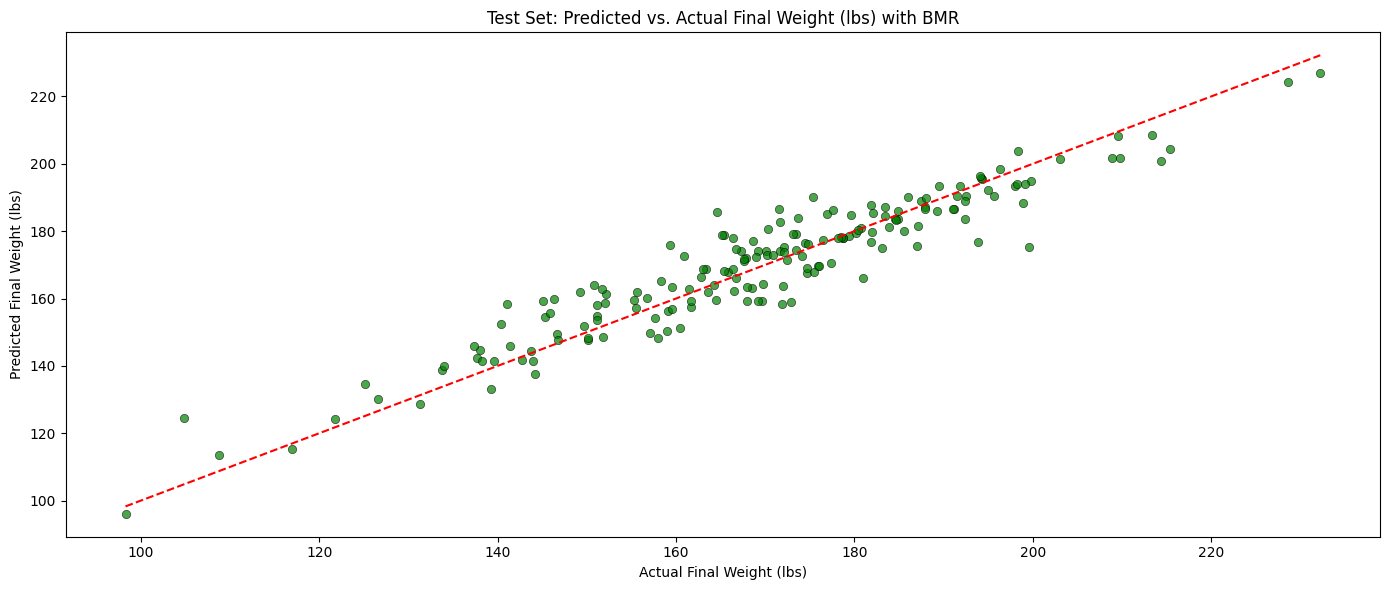

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Initialize the model with BMR
model_with_bmr_reduced = LinearRegression()
model_with_bmr_reduced.fit(X_train_reduced_with_bmr, y_train_reduced)

# prediction on train dataset
y_pred_train_with_bmr_reduced = model_with_bmr_reduced.predict(X_train_reduced_with_bmr)
rmse_train_with_bmr_reduced = root_mean_squared_error(y_train_reduced, y_pred_train_with_bmr_reduced)
r2_train_with_bmr_reduced = r2_score(y_train_reduced, y_pred_train_with_bmr_reduced)

# prediction on test dataset
y_pred_test_with_bmr_reduced = model_with_bmr_reduced.predict(X_test_reduced_with_bmr)
lr_rmse_test_with_bmr_reduced = root_mean_squared_error(y_test_reduced, y_pred_test_with_bmr_reduced)
lr_r2_test_with_bmr_reduced = r2_score(y_test_reduced, y_pred_test_with_bmr_reduced)

# print the results
print("With BMR (reduced dataset):")
print("Training set:")
print("  RMSE:", rmse_train_with_bmr_reduced)
print("  R²:", r2_train_with_bmr_reduced)
print("Test set:")
print("  RMSE:", lr_rmse_test_with_bmr_reduced)
print("  R²:", lr_r2_test_with_bmr_reduced)

# plot the test
plt.figure(figsize=(14, 6))

sns.scatterplot(x=y_test_reduced, y=y_pred_test_with_bmr_reduced, alpha=0.7, color='green', edgecolor='k')
plt.plot([y_test_reduced.min(), y_test_reduced.max()], [y_test_reduced.min(), y_test_reduced.max()], color='red', linestyle='--')
plt.xlabel("Actual Final Weight (lbs)")
plt.ylabel("Predicted Final Weight (lbs)")
plt.title("Test Set: Predicted vs. Actual Final Weight (lbs) with BMR")

plt.tight_layout()
plt.show()

Without BMR (reduced dataset):
Training set:
  RMSE: 16.42705184682268
  R²: 0.2850677274039387
Test set:
  RMSE: 18.21717049183842
  R²: 0.3157126573305362


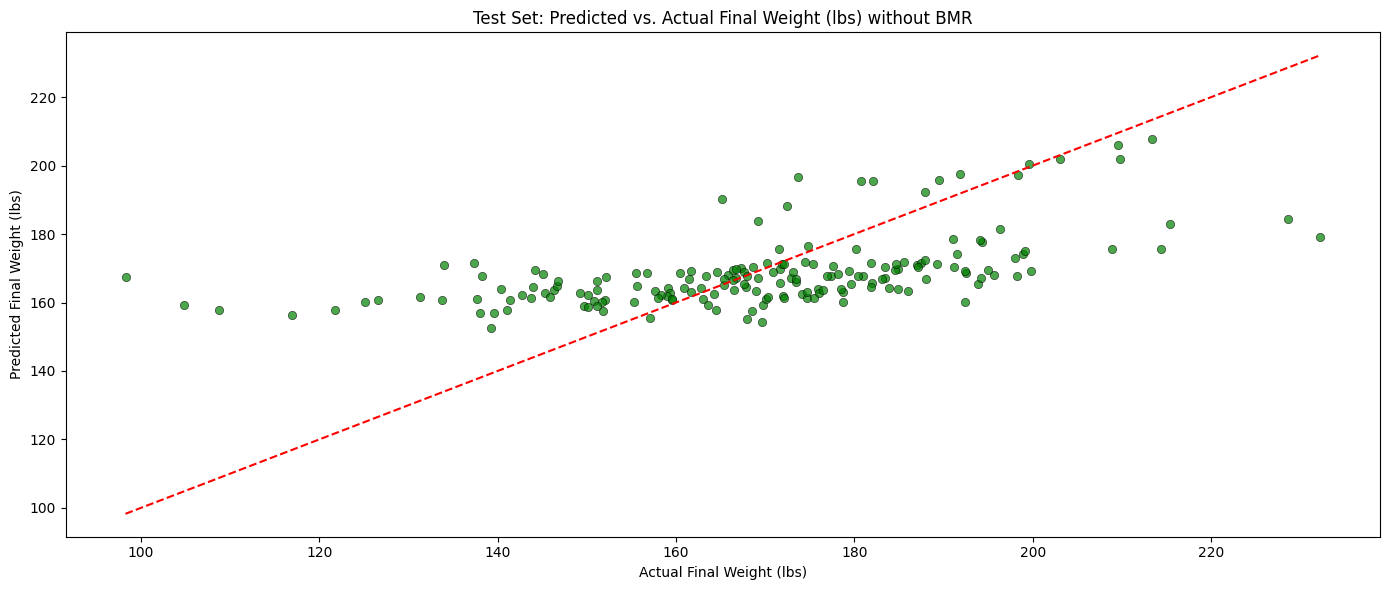

In [37]:
# # Initialize the model without BMR
model_without_bmr_reduced = LinearRegression()
model_without_bmr_reduced.fit(X_train_reduced_without_bmr, y_train_reduced)

# predictions on train
y_pred_train_without_bmr_reduced = model_without_bmr_reduced.predict(X_train_reduced_without_bmr)
rmse_train_without_bmr_reduced = root_mean_squared_error(y_train_reduced, y_pred_train_without_bmr_reduced)
r2_train_without_bmr_reduced = r2_score(y_train_reduced, y_pred_train_without_bmr_reduced)

# prediction on test
y_pred_test_without_bmr_reduced = model_without_bmr_reduced.predict(X_test_reduced_without_bmr)
lr_rmse_test_without_bmr_reduced = root_mean_squared_error(y_test_reduced, y_pred_test_without_bmr_reduced)
lr_r2_test_without_bmr_reduced = r2_score(y_test_reduced, y_pred_test_without_bmr_reduced)

# print the results
print("Without BMR (reduced dataset):")
print("Training set:")
print("  RMSE:", rmse_train_without_bmr_reduced)
print("  R²:", r2_train_without_bmr_reduced)
print("Test set:")
print("  RMSE:", lr_rmse_test_without_bmr_reduced)
print("  R²:", lr_r2_test_without_bmr_reduced)

# Plot 
plt.figure(figsize=(14, 6))

sns.scatterplot(x=y_test_reduced, y=y_pred_test_without_bmr_reduced, alpha=0.7, color='green', edgecolor='k')
plt.plot([y_test_reduced.min(), y_test_reduced.max()], [y_test_reduced.min(), y_test_reduced.max()], color='red', linestyle='--')
plt.xlabel("Actual Final Weight (lbs)")
plt.ylabel("Predicted Final Weight (lbs)")
plt.title("Test Set: Predicted vs. Actual Final Weight (lbs) without BMR")

plt.tight_layout()
plt.show()

The scatter plots above illustrate the model's performance in predicting the final weight with and without including the BMR feature.

With BMR: The first plot, where BMR is included, shows a closer alignment of predicted weights to the actual values, as indicated by the green points being closer to the red dashed line (ideal fit). This suggests that the model captures the weight variability more accurately when BMR is included. In fact we obtained a RMSE = 8.603 and R^2 = 0.847 on the test set

Without BMR: The second plot, where BMR is excluded, shows more dispersion, especially at the extremes. The predicted weights deviate further from the actual values, indicating a reduced accuracy in capturing the relationship between features and the final weight. the model without BMR might not be complex enough to capture all the variability in predicting the final weight. In fact we obtained RMSE = 18.926 and R^2 = 0.261 on the test set

### b. Linear Regression Using Batch Gradient Descent

#### function

In [38]:
from sklearn.metrics import r2_score

def batch_gradient_descent(X_train, y_train, X_test, y_test, learning_rate=0.01, n_iterations=1000, tolerance=1e-6):
    m = X_train.shape[0]  # Number of training examples
    theta = np.random.randn(X_train.shape[1] + 1, 1).flatten()  # Initialize theta with random values

    # Add a column of 1s to X_train and X_test to account for the intercept
    X_b_train = np.c_[np.ones((m, 1)), X_train]
    X_b_test = np.c_[np.ones((len(X_test), 1)), X_test]

    RMSE_train = []
    RMSE_test = []
    early_stop_iteration = None

    for iteration in range(n_iterations):
        # Make predictions on the training set
        y_pred_train = X_b_train.dot(theta)
        
        # Calculate gradients for each parameter in theta
        gradients = 2/m * X_b_train.T.dot(y_pred_train - y_train)
        
        # Update theta by taking a step in the opposite direction of the gradient
        theta = theta - learning_rate * gradients

        # Calculate RMSE for both training and test sets
        current_rmse_train = root_mean_squared_error(y_train, y_pred_train)
        y_pred_test = X_b_test.dot(theta)
        current_rmse_test = root_mean_squared_error(y_test, y_pred_test)

        RMSE_train.append(current_rmse_train)
        RMSE_test.append(current_rmse_test)

        # Early stopping: Stop if the improvement in RMSE is very small
        if iteration > 0 and abs(RMSE_train[-2] - RMSE_train[-1]) < tolerance:
            early_stop_iteration = iteration
            break

    return theta, RMSE_train, RMSE_test, early_stop_iteration

#### LR batch gradient descent with feature BMR

In [39]:
learning_rates = np.round(np.arange(0, 0.05, 0.01), 2)
best_batch_eta = None
best_batch_rmse = float('inf')
best_batch_theta = None
best_batch_rmse_train_BMR = []
best_batch_rmse_test_BMR = []
best_batch_stop_iteration = None

# Loop over each learning rate
for eta in learning_rates:
    theta, rmse_train, rmse_test, stop_iteration = batch_gradient_descent(
        X_train_reduced_with_bmr, y_train, X_test_reduced_with_bmr, y_test, learning_rate=eta, n_iterations=20000, tolerance=1e-6
    )
    final_rmse = rmse_test[-1]
    
    # Check if this learning rate gives a better RMSE on the test set
    if final_rmse < best_batch_rmse:
        best_batch_rmse = final_rmse
        best_batch_eta = eta
        best_batch_theta = theta
        best_batch_rmse_train_BMR = rmse_train
        best_batch_rmse_test_BMR = rmse_test
        best_batch_stop_iteration = stop_iteration

print(f"Best learning rate: {best_batch_eta}, Final RMSE on test set: {best_batch_rmse}")
print("Best theta values:", best_batch_theta)

Best learning rate: 0.04, Final RMSE on test set: 7.221377162411642
Best theta values: [ 1.62293256e+02  3.50394147e+00  3.03053143e+00 -1.17824441e+00
 -7.09781150e-01  3.93334798e+00  3.28205954e+00  1.89554071e+01
  2.85735599e+00 -5.89569720e-03]


we can see that some features have a very significant impact while others do not. Furthermore, The learning rate of 0.04 and these theta values yield an effective model with low RMSE, capturing the relationship between features and the target well.

In [40]:
print("size X_train_reduced_with_bmr:", X_train_reduced_with_bmr.shape)
print("size X_test_reduced_with_bmr:", X_test_reduced_with_bmr.shape)
print("size di best_theta:", best_batch_theta.shape)

size X_train_reduced_with_bmr: (420, 9)
size X_test_reduced_with_bmr: (180, 9)
size di best_theta: (10,)


In [41]:
# Calculate predictions on the training set with BMR using best_theta
X_b_train_with_bmr = np.c_[np.ones((len(X_train_reduced_with_bmr), 1)), X_train_reduced_with_bmr]  #add column of 1
y_pred_train_with_bmr = X_b_train_with_bmr.dot(best_batch_theta)

# calculate rmse and r^2 on train set
train_rmse_with_bmr = root_mean_squared_error(y_train, y_pred_train_with_bmr)
train_r2_with_bmr = r2_score(y_train, y_pred_train_with_bmr)

 
# Calculate predictions on the test set with BMR using best_theta
X_b_test_with_bmr = np.c_[np.ones((len(X_test_reduced_with_bmr), 1)), X_test_reduced_with_bmr]  
y_pred_test_with_bmr = X_b_test_with_bmr.dot(best_batch_theta)

# calculate rmse and r^2 on test set
batch_test_rmse_with_bmr = root_mean_squared_error(y_test, y_pred_test_with_bmr)
batch_test_r2_with_bmr = r2_score(y_test, y_pred_test_with_bmr)

# print results
print("Train RMSE (with BMR) = {}".format(train_rmse_with_bmr))
print("Train R² (with BMR) = {}".format(train_r2_with_bmr))
print("Test RMSE (with BMR) = {}".format(batch_test_rmse_with_bmr))
print("Test R² (with BMR) = {}".format(batch_test_r2_with_bmr))

Train RMSE (with BMR) = 7.327060739304581
Train R² (with BMR) = 0.8577654085487817
Test RMSE (with BMR) = 7.221377162411642
Test R² (with BMR) = 0.8924732009484792


 The model performs consistently well on both training and test sets, with low RMSE and high R^2 values, indicating that it generalizes effectively. Including BMR as a feature contributes to the model's strong predictive power.

#### LR batch gradient descent without feature BMR

In [42]:
# Batch gradient descent without BMR
# Input parameters for the reduced dataset without BMR
learning_rates = np.round(np.arange(0, 0.1, 0.01), 2)
best_batch_eta_without_bmr = None
best_batch_rmse_without_bmr = float('inf')
best_batch_theta_without_bmr = None
best_batch_rmse_train_without_bmr = []
best_batch_rmse_test_without_bmr = []
best_batch_stop_iteration_without_bmr = None

for eta in learning_rates:
    theta, rmse_train, rmse_test, stop_iteration = batch_gradient_descent(
        X_train_reduced_without_bmr, y_train_reduced, X_test_reduced_without_bmr, y_test_reduced,
        learning_rate=eta, n_iterations=10000, tolerance=1e-6
    )
    final_rmse = rmse_test[-1]
    if final_rmse < best_batch_rmse_without_bmr:
        best_batch_rmse_without_bmr = final_rmse
        best_batch_eta_without_bmr = eta
        best_batch_theta_without_bmr = theta
        best_batch_rmse_train_without_bmr = rmse_train
        best_batch_rmse_test_without_bmr = rmse_test
        best_batch_stop_iteration_without_bmr = stop_iteration

print(f"Best learning rate (without BMR): {best_batch_eta_without_bmr}, RMSE on test set: {best_batch_rmse_without_bmr}")
print("Optimal theta values (without BMR):", best_batch_theta_without_bmr)


Best learning rate (without BMR): 0.09, RMSE on test set: 18.234411752622798
Optimal theta values (without BMR): [ 1.98892953e+02 -4.60846475e+01  9.86979976e+00 -6.20933821e+00
 -2.08693048e+00 -1.44200853e-01  2.95134341e-01 -5.47956769e-01
 -9.95130961e-01]


Here again, as before, we can see that some features have a very significant impact while others do not. the RMSE has increased a lot and the learning rate has also increased

In [43]:
# Calculate predictions on the training set without BMR using best_theta
X_b_train_without_bmr = np.c_[np.ones((len(X_train_reduced_without_bmr), 1)), X_train_reduced_without_bmr] 
y_pred_train_without_bmr = X_b_train_without_bmr.dot(best_batch_theta_without_bmr)

# Calculates RMSE and R² for the training set without BMR
train_rmse_without_bmr = root_mean_squared_error(y_train_reduced, y_pred_train_without_bmr)
train_r2_without_bmr = r2_score(y_train_reduced, y_pred_train_without_bmr)

X_b_test_without_bmr = np.c_[np.ones((len(X_test_reduced_without_bmr), 1)), X_test_reduced_without_bmr]  
y_pred_test_without_bmr = X_b_test_without_bmr.dot(best_batch_theta_without_bmr)

# Calculates RMSE and R² for the test set without BMR
batch_test_rmse_without_bmr = root_mean_squared_error(y_test_reduced, y_pred_test_without_bmr)
batch_test_r2_without_bmr = r2_score(y_test_reduced, y_pred_test_without_bmr)

# print results
print("Train RMSE (without BMR) = {}".format(train_rmse_without_bmr))
print("Train R² (without BMR) = {}".format(train_r2_without_bmr))
print("Test RMSE (without BMR) = {}".format(batch_test_rmse_without_bmr))
print("Test R² (without BMR) = {}".format(batch_test_r2_without_bmr))


Train RMSE (without BMR) = 16.427237155116337
Train R² (without BMR) = 0.2850515974704605
Test RMSE (without BMR) = 18.234411752622798
Test R² (without BMR) = 0.31441678544900364


as might be expected, the results of the model without BMR are significantly worse than the model with BMR as it is unable to generalize

### c. Mini_Batch Gradient Descent

#### function

In [44]:
def mini_batch_gradient_descent(X_train, y_train, X_test, y_test, learning_rate=0.01, batch_size=32, n_iterations=1000, tolerance=1e-6):
    m = X_train.shape[0]  # Number of samples in the training set
    theta = np.random.randn(X_train.shape[1] + 1, 1).flatten()  # Initialise theta with random values

    # add 1 columns for the intercept
    X_b_train = np.c_[np.ones((m, 1)), X_train]
    X_b_test = np.c_[np.ones((len(X_test), 1)), X_test]

    RMSE_train = []
    RMSE_test = []
    early_stop_iteration = None

    for iteration in range(n_iterations):
        # Shuffling 
        indices = np.random.permutation(m)
        X_b_train_shuffled = X_b_train[indices]
        y_train_shuffled = np.array(y_train)[indices]  # Convert in an arrayx

        for start_idx in range(0, m, batch_size):
            end_idx = start_idx + batch_size
            X_batch = X_b_train_shuffled[start_idx:end_idx]
            y_batch = y_train_shuffled[start_idx:end_idx]

            # prediction mini-batch
            y_pred_batch = X_batch.dot(theta)
            gradients = 2 / X_batch.shape[0] * X_batch.T.dot(y_pred_batch - y_batch)

            # Update theta
            theta = theta - learning_rate * gradients

        # Calculates RMSE over the entire training and test set to monitor convergence
        y_pred_train = X_b_train.dot(theta)
        y_pred_test = X_b_test.dot(theta)
        current_rmse_train = root_mean_squared_error(y_train, y_pred_train)
        current_rmse_test = root_mean_squared_error(y_test, y_pred_test)

        RMSE_train.append(current_rmse_train)
        RMSE_test.append(current_rmse_test)

        # Early stopping
        if iteration > 0 and abs(RMSE_train[-2] - RMSE_train[-1]) < tolerance:
            early_stop_iteration = iteration
            break

    return theta, RMSE_train, RMSE_test, early_stop_iteration


#### Mini_Batch with BMR

In [45]:
# Define parameters for mini-batch gradient descent with BMR
learning_rates = [0.0001, 0.001, 0.01, 0.03]
batch_sizes = [16, 32, 64, 128]
best_mini_batch_eta_BMR = None
best_mini_batch_size_BMR = None
best_mini_batch_rmse_BMR = float('inf')
best_mini_batch_theta_BMR = None
best_mini_batch_rmse_train_BMR = []
best_mini_batch_rmse_test_BMR = []
best_mini_batch_stop_iteration_BMR = None

# Loop to test different combinations of learning rates and batch sizes
for eta in learning_rates:
    for batch_size in batch_sizes:
        theta, rmse_train, rmse_test, stop_iteration = mini_batch_gradient_descent(
            X_train_reduced_with_bmr, y_train, X_test_reduced_with_bmr, y_test, 
            learning_rate=eta, batch_size=batch_size, n_iterations=1000, tolerance=1e-6
        )
        final_rmse = rmse_test[-1]
        
        # Update best parameters if current combination has lower RMSE
        if final_rmse < best_mini_batch_rmse_BMR:
            best_mini_batch_rmse_BMR = final_rmse
            best_mini_batch_eta_BMR = eta
            best_mini_batch_size_BMR = batch_size
            best_mini_batch_theta_BMR = theta
            best_mini_batch_rmse_train_BMR = rmse_train
            best_mini_batch_rmse_test_BMR = rmse_test
            best_mini_batch_stop_iteration_BMR = stop_iteration

print(f"Best learning rate (Mini-Batch with BMR): {best_mini_batch_eta_BMR}")
print(f"Best batch size (Mini-Batch with BMR): {best_mini_batch_size_BMR}")
print(f"Final RMSE on test set (Mini-Batch with BMR): {best_mini_batch_rmse_BMR}")
print("Optimal theta values (Mini-Batch with BMR):", best_mini_batch_theta_BMR)



Best learning rate (Mini-Batch with BMR): 0.03
Best batch size (Mini-Batch with BMR): 64
Final RMSE on test set (Mini-Batch with BMR): 7.197118445507837
Optimal theta values (Mini-Batch with BMR): [ 1.62442642e+02  3.37142951e+00  3.00341447e+00 -1.14090986e+00
 -7.33245879e-01  3.76183585e+00  3.27488415e+00  1.89059445e+01
  2.95303090e+00 -4.33764693e-02]


In [46]:
X_b_test = np.c_[np.ones((len(X_test_reduced_with_bmr), 1)), X_test_reduced_with_bmr]  
y_pred_test = X_b_test.dot(best_mini_batch_theta_BMR)

#  RMSE e R² on test set with BMR
mini_batch_test_rmse = root_mean_squared_error(y_test, y_pred_test)
mini_batch_test_r2 = r2_score(y_test, y_pred_test)

print("Test RMSE = {}".format(mini_batch_test_rmse))
print("Test R² = {}".format(mini_batch_test_r2))

Test RMSE = 7.197118445507837
Test R² = 0.8931944154275749


#### Mini-Batch without BMR

In [47]:
# Loop to find the best learning rate and batch size for the dataset without BMR
learning_rates = [0.0001, 0.001, 0.01]
batch_sizes = [16, 32, 64, 128]
best_mini_batch_eta_without_bmr = None
best_mini_batch_size_without_bmr = None
best_mini_batch_rmse_without_bmr = float('inf')
best_mini_batch_theta_without_bmr = None
best_mini_batch_rmse_train_without_bmr = []
best_mini_batch_rmse_test_without_bmr = []
best_mini_batch_stop_iteration_without_bmr = None

for eta in learning_rates:
    for batch_size in batch_sizes:
        theta, rmse_train, rmse_test, stop_iteration = mini_batch_gradient_descent(
            X_train_reduced_without_bmr, y_train, X_test_reduced_without_bmr, y_test, 
            learning_rate=eta, batch_size=batch_size, n_iterations=10000, tolerance=1e-6
        )
        final_rmse = rmse_test[-1]
        
        # Update the optimal parameters if this configuration is the best so far
        if final_rmse < best_mini_batch_rmse_without_bmr:
            best_mini_batch_rmse_without_bmr = final_rmse
            best_mini_batch_eta_without_bmr = eta
            best_mini_batch_size_without_bmr = batch_size
            best_mini_batch_theta_without_bmr = theta
            best_mini_batch_rmse_train_without_bmr = rmse_train
            best_mini_batch_rmse_test_without_bmr = rmse_test
            best_mini_batch_stop_iteration_without_bmr = stop_iteration

print(f"Best learning rate (without BMR): {best_mini_batch_eta_without_bmr}")
print(f"Best batch size (without BMR): {best_mini_batch_size_without_bmr}")
print(f"Final RMSE on test set (without BMR): {best_mini_batch_rmse_without_bmr}")
print("Optimal theta values (without BMR):", best_mini_batch_theta_without_bmr)



Best learning rate (without BMR): 0.01
Best batch size (without BMR): 32
Final RMSE on test set (without BMR): 18.17084102998429
Optimal theta values (without BMR): [ 1.99510662e+02 -4.62643088e+01  9.88415330e+00 -6.18472196e+00
 -2.45711055e+00 -1.96099139e-01  1.89433536e-01 -4.58523225e-01
 -1.30895093e+00]


In [48]:
X_b_test_without_bmr = np.c_[np.ones((len(X_test_reduced_without_bmr), 1)), X_test_reduced_without_bmr]
y_pred_test_without_bmr = X_b_test_without_bmr.dot(best_mini_batch_theta_without_bmr)

#   RMSE e R² on test set without BMR
mini_batch_test_rmse_without_bmr = root_mean_squared_error(y_test, y_pred_test_without_bmr)
mini_batch_test_r2_without_bmr = r2_score(y_test, y_pred_test_without_bmr)

print("Test RMSE (without BMR) = {}".format(mini_batch_test_rmse_without_bmr))
print("Test R² (without BMR) = {}".format(mini_batch_test_r2_without_bmr))

Test RMSE (without BMR) = 18.17084102998429
Test R² (without BMR) = 0.319188757159967



Also in the case of the mini-batch model, as with linear regression and batch gradient descent, the model with the BMR feature achieves significantly better RMSE and R^2 values than the model without BMR. This improvement is likely because BMR captures essential information related to the target variable, providing the model with a key predictor of final weight

### d. Dataset Augmentation

In [49]:
from sklearn.preprocessing import PolynomialFeatures

# Define the grade of the polynomial (I chose degree 2)
poly = PolynomialFeatures(degree=2, include_bias=False)

# Apply PolynomialFeatures to dataset with BMR
X_train_augmented_with_bmr = poly.fit_transform(X_train)
X_test_augmented_with_bmr = poly.transform(X_test)

# create copy for the other case
X_train_without_bmr = X_train.copy().drop(columns=['BMR (Calories)'], errors='ignore')
X_test_without_bmr = X_test.copy().drop(columns=['BMR (Calories)'], errors='ignore')

# Apply PolynomialFeatures to dataset without BMR
X_train_augmented_without_bmr = poly.fit_transform(X_train_without_bmr)
X_test_augmented_without_bmr = poly.transform(X_test_without_bmr)


In [50]:
print(f"Original dimensions: X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"Dimension of augmented dataset: X_train:{X_train_augmented_with_bmr.shape}, X_test: {X_test_augmented_with_bmr.shape}")
print(f"Dimension fo augmented dataset without BMR: X_train:{X_train_augmented_without_bmr.shape}, X_test: {X_test_augmented_without_bmr.shape}")

Original dimensions: X_train: (420, 17), X_test: (180, 17)
Dimension of augmented dataset: X_train:(420, 170), X_test: (180, 170)
Dimension fo augmented dataset without BMR: X_train:(420, 152), X_test: (180, 152)


In [51]:
# Define the range of learning rates to test
learning_rates = [0.001, 0.005, 0.01]

# Variables to store the best parameters for the augmented dataset with BMR
best_eta_augmented_with_bmr = None
best_rmse_augmented_with_bmr = float('inf')
best_theta_augmented_with_bmr = None
best_rmse_train_augmented_with_bmr = []
best_rmse_test_augmented_with_bmr = []
best_stop_iteration_augmented_with_bmr = None

# Loop over each learning rate to find the optimal one for the dataset with BMR
for eta in learning_rates:
    theta, rmse_train, rmse_test, stop_iteration = batch_gradient_descent(
        X_train_augmented_with_bmr, y_train, X_test_augmented_with_bmr, y_test,
        learning_rate=eta, n_iterations=10000, tolerance=1e-6
    )
    final_rmse = rmse_test[-1]
    
    # Update the best parameters if the current RMSE is the lowest
    if final_rmse < best_rmse_augmented_with_bmr:
        best_rmse_augmented_with_bmr = final_rmse
        best_eta_augmented_with_bmr = eta
        best_theta_augmented_with_bmr = theta
        best_rmse_train_augmented_with_bmr = rmse_train
        best_rmse_test_augmented_with_bmr = rmse_test
        best_stop_iteration_augmented_with_bmr = stop_iteration

print(f"Best learning rate (with BMR): {best_eta_augmented_with_bmr}")
print(f"Final RMSE on test set (with BMR): {best_rmse_augmented_with_bmr}")


Best learning rate (with BMR): 0.01
Final RMSE on test set (with BMR): 8.12840908075666


the polynomial model with the BMR feature obtained an RMSE on the train set in line with the others.

In [52]:
# Repeat the process for the dataset without BMR
best_eta_augmented_without_bmr = None
best_rmse_augmented_without_bmr = float('inf')
best_theta_augmented_without_bmr = None
best_rmse_train_augmented_without_bmr = []
best_rmse_test_augmented_without_bmr = []
best_stop_iteration_augmented_without_bmr = None

for eta in learning_rates:
    theta, rmse_train, rmse_test, stop_iteration = batch_gradient_descent(
        X_train_augmented_without_bmr, y_train, X_test_augmented_without_bmr, y_test,
        learning_rate=eta, n_iterations=10000, tolerance=1e-6
    )
    final_rmse = rmse_test[-1]
    
    # Update the best parameters if the current RMSE is the lowest
    if final_rmse < best_rmse_augmented_without_bmr:
        best_rmse_augmented_without_bmr = final_rmse
        best_eta_augmented_without_bmr = eta
        best_theta_augmented_without_bmr = theta
        best_rmse_train_augmented_without_bmr = rmse_train
        best_rmse_test_augmented_without_bmr = rmse_test
        best_stop_iteration_augmented_without_bmr = stop_iteration

print(f"Best learning rate (without BMR): {best_eta_augmented_without_bmr}")
print(f"Final RMSE on test set (without BMR): {best_rmse_augmented_without_bmr}")

Best learning rate (without BMR): 0.01
Final RMSE on test set (without BMR): 16.273634880893642


it can already be seen that the RMSE of the polynomial model without the BMR feature is better than all other models without the BMR feature

In [53]:
# Calculate final predictions on the training and test sets using the best theta
X_b_train_augmented_with_bmr = np.c_[np.ones((X_train_augmented_with_bmr.shape[0], 1)), X_train_augmented_with_bmr]
X_b_test_augmented_with_bmr = np.c_[np.ones((X_test_augmented_with_bmr.shape[0], 1)), X_test_augmented_with_bmr]

y_pred_train_augmented_with_bmr = X_b_train_augmented_with_bmr.dot(best_theta_augmented_with_bmr)
y_pred_test_augmented_with_bmr = X_b_test_augmented_with_bmr.dot(best_theta_augmented_with_bmr)

# Calculate RMSE for both training and test sets
train_rmse_augmented_with_bmr = root_mean_squared_error(y_train, y_pred_train_augmented_with_bmr)
poly_test_rmse_augmented_with_bmr = root_mean_squared_error(y_test, y_pred_test_augmented_with_bmr)

# Calculate R² for both training and test sets
train_r2_augmented_with_bmr = r2_score(y_train, y_pred_train_augmented_with_bmr)
poly_test_r2_augmented_with_bmr = r2_score(y_test, y_pred_test_augmented_with_bmr)

# Print RMSE and R² results
print(f"Train RMSE (with BMR) = {train_rmse_augmented_with_bmr}")
print(f"Train R² (with BMR) = {train_r2_augmented_with_bmr}")
print(f"Test RMSE (with BMR) = {poly_test_rmse_augmented_with_bmr}")
print(f"Test R² (with BMR) = {poly_test_r2_augmented_with_bmr}")


Train RMSE (with BMR) = 5.606756359198659
Train R² (with BMR) = 0.9167145733637657
Test RMSE (with BMR) = 8.12840908075666
Test R² (with BMR) = 0.863765291791566


the polynomial model also performed better than the other models on the dataset with the BMR feature, although a slight discrepancy between RMSE of the training and RMSE of the test can be seen

In [54]:
# Calculate final predictions on the training and test sets using the best theta for the dataset without BMR
X_b_train_augmented_without_bmr = np.c_[np.ones((X_train_augmented_without_bmr.shape[0], 1)), X_train_augmented_without_bmr]
X_b_test_augmented_without_bmr = np.c_[np.ones((X_test_augmented_without_bmr.shape[0], 1)), X_test_augmented_without_bmr]

y_pred_train_augmented_without_bmr = X_b_train_augmented_without_bmr.dot(best_theta_augmented_without_bmr)
y_pred_test_augmented_without_bmr = X_b_test_augmented_without_bmr.dot(best_theta_augmented_without_bmr)

# Calculate RMSE for both training and test sets
train_rmse_augmented_without_bmr = root_mean_squared_error(y_train, y_pred_train_augmented_without_bmr)
poly_test_rmse_augmented_without_bmr = root_mean_squared_error(y_test, y_pred_test_augmented_without_bmr)

# Calculate R² for both training and test sets
train_r2_augmented_without_bmr = r2_score(y_train, y_pred_train_augmented_without_bmr)
poly_test_r2_augmented_without_bmr = r2_score(y_test, y_pred_test_augmented_without_bmr)

# Print RMSE and R² results
print(f"Train RMSE (without BMR) = {train_rmse_augmented_without_bmr}")
print(f"Train R² (without BMR) = {train_r2_augmented_without_bmr}")
print(f"Test RMSE (without BMR) = {poly_test_rmse_augmented_without_bmr}")
print(f"Test R² (without BMR) = {poly_test_r2_augmented_without_bmr}")


Train RMSE (without BMR) = 11.32479111127026
Train R² (without BMR) = 0.6602135576187886
Test RMSE (without BMR) = 16.273634880893642
Test R² (without BMR) = 0.4539331698925091


The increased complexity of the polynomial model has allowed for a more accurate fit, even improving predictions compared to simpler models without BMR. This higher complexity enables the model to capture more intricate relationships within the data, enhancing predictive accuracy and narrowing the performance gap between models with and without BMR. However, we can also see a gap between R^2 of the training set and that of the test set

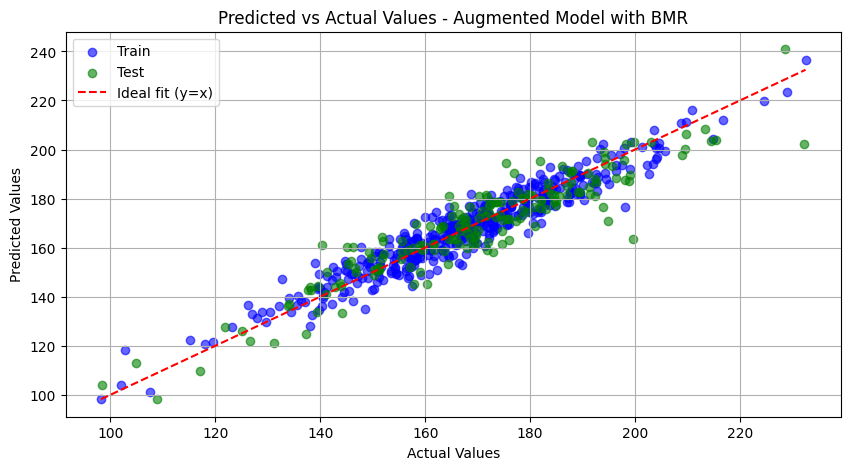

In [55]:
# Predicted vs. Actual Values Plot for Training and Test Sets
def plot_predicted_vs_actual(y_true_train, y_pred_train, y_true_test, y_pred_test, title):
    plt.figure(figsize=(10, 5))
    
    # Training set
    plt.scatter(y_true_train, y_pred_train, color='blue', label='Train', alpha=0.6)
    # Test set
    plt.scatter(y_true_test, y_pred_test, color='green', label='Test', alpha=0.6)
    
    # Plot the ideal line (y = x) for reference
    min_val = min(min(y_true_train), min(y_true_test))
    max_val = max(max(y_true_train), max(y_true_test))
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal fit (y=x)')
    
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Predicted vs Actual Values - {title}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the plot functions with your data
# For the augmented dataset with BMR
plot_predicted_vs_actual(
    y_true_train=y_train,
    y_pred_train=y_pred_train_augmented_with_bmr,
    y_true_test=y_test,
    y_pred_test=y_pred_test_augmented_with_bmr,
    title="Augmented Model with BMR"
)


Overall, this plot confirms the model’s strong predictive capability and generalization on unseen data.

### e. Compare Learning Curves

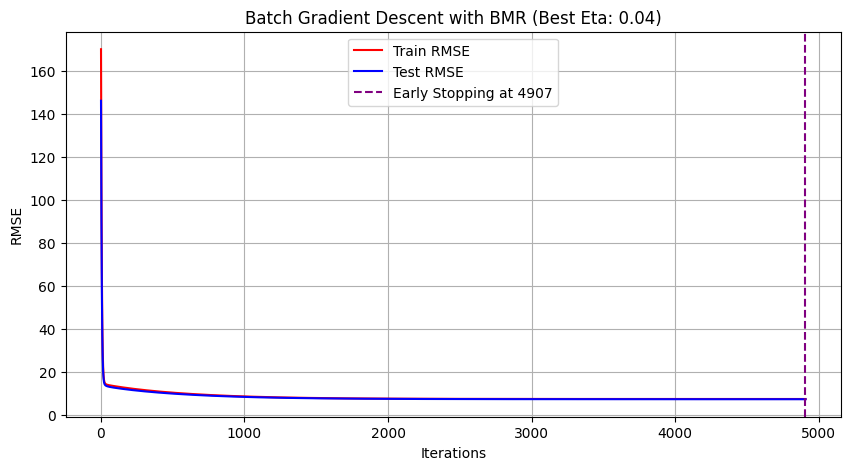

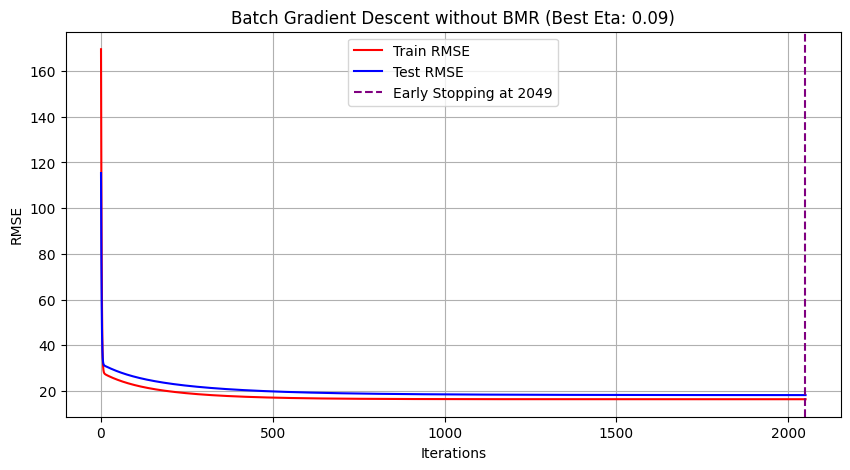

In [56]:
import matplotlib.pyplot as plt

def plot_rmse_convergence(train_rmse, test_rmse, best_eta, title, early_stop_iteration=None, batch_size=None):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_rmse) + 1), train_rmse, label='Train RMSE', color='red')
    plt.plot(range(1, len(test_rmse) + 1), test_rmse, label='Test RMSE', color='blue')
    
    if early_stop_iteration:
        plt.axvline(x=early_stop_iteration, color='purple', linestyle='--', label=f'Early Stopping at {early_stop_iteration}')
    
    plt.xlabel('Iterations')
    plt.ylabel('RMSE')
    
    # Include batch size in the title if provided
    if batch_size:
        plt.title(f'{title} (Eta: {best_eta}, Batch Size: {batch_size})')
    else:
        plt.title(f'{title} (Best Eta: {best_eta})')
    
    plt.legend()
    plt.grid(True)
    plt.show()

# Data for each model
# Batch Gradient Descent
plot_rmse_convergence(
    train_rmse=best_batch_rmse_train_BMR, 
    test_rmse=best_batch_rmse_test_BMR, 
    best_eta=best_batch_eta, 
    title='Batch Gradient Descent with BMR',
    early_stop_iteration=best_batch_stop_iteration
)

plot_rmse_convergence(
    train_rmse=best_batch_rmse_train_without_bmr, 
    test_rmse=best_batch_rmse_test_without_bmr, 
    best_eta=best_batch_eta_without_bmr, 
    title='Batch Gradient Descent without BMR',
    early_stop_iteration=best_batch_stop_iteration_without_bmr
)



In these learning curves, we observe the performance of batch gradient descent models trained with and without the BMR feature. The model with BMR uses a lower learning rate and takes more iterations to reach optimal performance, while the model without BMR requires a higher learning rate to converge effectively.

- BMR’s Impact: The model with BMR achieves lower RMSE and requires more iterations, reflecting its higher complexity and accuracy.
- Generalization: Both models show similar RMSE trends for train and test sets, but the model without BMR has a higher overall error, underscoring BMR’s role in improving predictive performance.

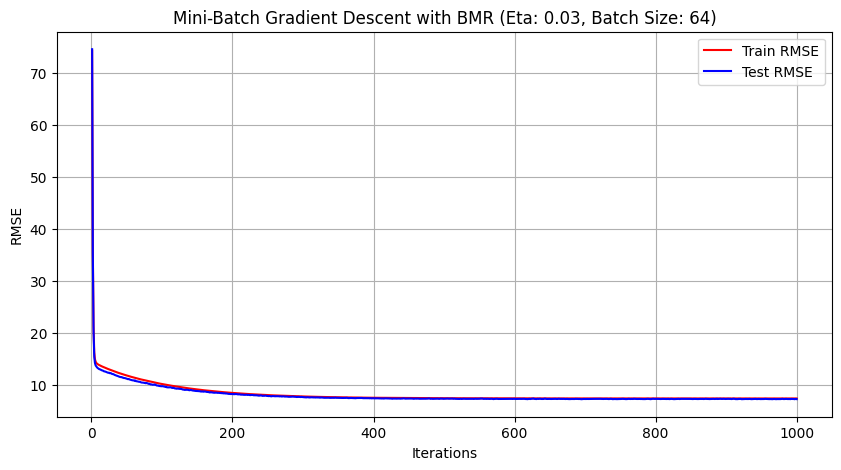

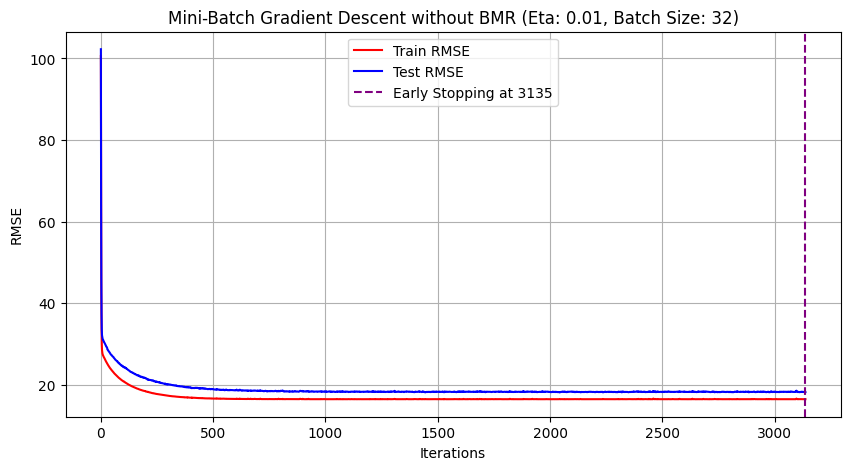

In [57]:
# Mini-Batch Gradient Descent with BMR 
plot_rmse_convergence(
    train_rmse=best_mini_batch_rmse_train_BMR, 
    test_rmse=best_mini_batch_rmse_test_BMR, 
    best_eta=best_mini_batch_eta_BMR, 
    title='Mini-Batch Gradient Descent with BMR',
    early_stop_iteration=best_mini_batch_stop_iteration_BMR,
    batch_size=best_mini_batch_size_BMR  # Pass the batch size here
)

# Mini-Batch Gradient Descent without BMR
plot_rmse_convergence(
    train_rmse=best_mini_batch_rmse_train_without_bmr, 
    test_rmse=best_mini_batch_rmse_test_without_bmr, 
    best_eta=best_mini_batch_eta_without_bmr, 
    title='Mini-Batch Gradient Descent without BMR',
    early_stop_iteration=best_mini_batch_stop_iteration_without_bmr,
    batch_size=best_mini_batch_size_without_bmr 
)

The top plot shows that the model with BMR (learning rate 0.03, batch size 32) converges efficiently within 1000 iterations, achieving low and stable RMSE for both training and test sets. This close alignment between train and test RMSE indicates strong generalization and minimal overfitting, emphasizing BMR's positive impact on model accuracy.

In contrast, the model without BMR (bottom plot) requires a lower learning rate (0.01) and takes longer to converge, with early stopping occurring at 2847 iterations. The final RMSE for both train and test sets is significantly higher, reflecting less accurate predictions and reduced performance.

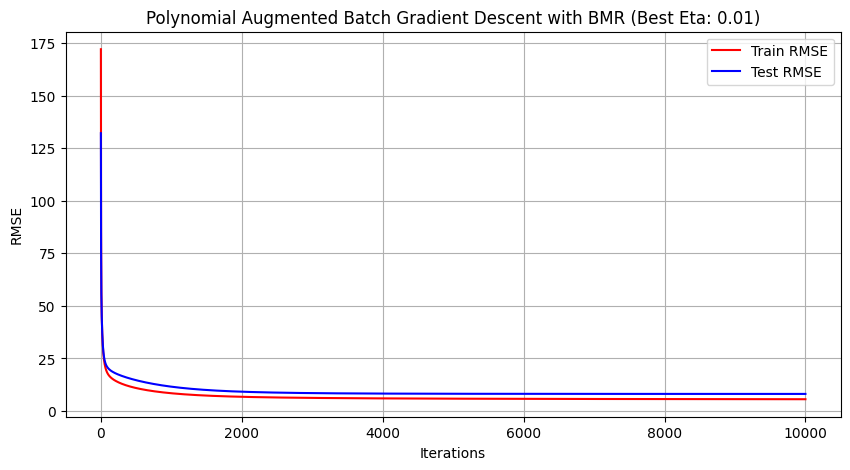

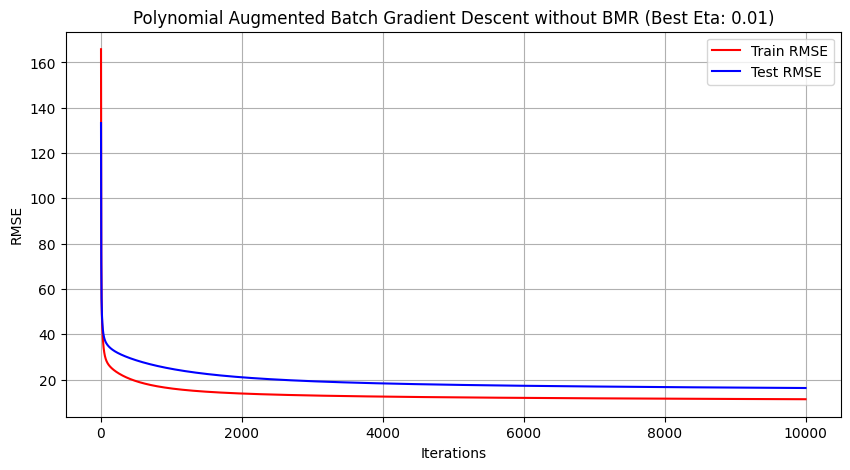

In [58]:
# polynomial-augmented dataset with BMR
plot_rmse_convergence(
    train_rmse=best_rmse_train_augmented_with_bmr, 
    test_rmse=best_rmse_test_augmented_with_bmr, 
    best_eta=best_eta_augmented_with_bmr, 
    title='Polynomial Augmented Batch Gradient Descent with BMR',
    early_stop_iteration=best_stop_iteration_augmented_with_bmr
)

# polynomial-augmented dataset without BMR
plot_rmse_convergence(
    train_rmse=best_rmse_train_augmented_without_bmr, 
    test_rmse=best_rmse_test_augmented_without_bmr, 
    best_eta=best_eta_augmented_without_bmr, 
    title='Polynomial Augmented Batch Gradient Descent without BMR',
    early_stop_iteration=best_stop_iteration_augmented_without_bmr
)


The model with BMR converges steadily over 10,000 iterations, reaching low RMSE values for both training and test sets. The test RMSE (blue) closely aligns with the train RMSE (red), indicating strong generalization and effective learning. This stability and low error demonstrate that the polynomial model with BMR captures complex relationships in the data well.

The model without BMR also converges but shows a consistently higher RMSE for the test set compared to the train set, suggesting some degree of overfitting. The gap between test and train RMSE implies that, without BMR, the model struggles to generalize as effectively, even with polynomial augmentation.

In [59]:
def calculate_rmse_vs_training_size(X_train, y_train, X_test, y_test, model_type='batch', learning_rate=0.01, n_iterations=1000, batch_size=None):
    training_sizes = np.linspace(0.1, 1.0, 10)  # Training set sizes from 10% to 100%
    train_rmse_list = []
    test_rmse_list = []

    for size in training_sizes:
        # Subset of the training data
        subset_size = int(len(X_train) * size)
        X_train_subset = X_train[:subset_size]
        y_train_subset = y_train[:subset_size]
        
        # Run the appropriate gradient descent method based on model_type
        if model_type == 'batch':
            # Call Batch Gradient Descent
            theta, train_rmse_values, test_rmse_values, _ = batch_gradient_descent(
                X_train_subset, y_train_subset, X_test, y_test, 
                learning_rate=learning_rate, n_iterations=n_iterations
            )
        
        elif model_type == 'mini_batch' and batch_size is not None:
            # Call Mini-Batch Gradient Descent
            theta, train_rmse_values, test_rmse_values, _ = mini_batch_gradient_descent(
                X_train_subset, y_train_subset, X_test, y_test, 
                learning_rate=learning_rate, batch_size=batch_size, n_iterations=n_iterations
            )
        
        else:
            raise ValueError("Unsupported model type or missing batch size for mini-batch.")

        # Record final RMSE values for this subset
        train_rmse_list.append(train_rmse_values[-1])
        test_rmse_list.append(test_rmse_values[-1])

    return training_sizes * 100, train_rmse_list, test_rmse_list


In [60]:
training_sizes_bmr, train_rmse_bmr, test_rmse_bmr = calculate_rmse_vs_training_size(
    X_train_reduced_with_bmr, y_train, X_test_reduced_with_bmr, y_test, 
    model_type='batch', learning_rate=best_batch_eta, n_iterations=10000
)

training_sizes_without_bmr, train_rmse_without_bmr, test_rmse_without_bmr = calculate_rmse_vs_training_size(
    X_train_reduced_without_bmr, y_train, X_test_reduced_without_bmr, y_test, 
    model_type='batch', learning_rate=best_batch_eta_without_bmr, n_iterations=10000
)

training_sizes_mini_bmr, train_rmse_mini_bmr, test_rmse_mini_bmr = calculate_rmse_vs_training_size(
    X_train_reduced_with_bmr, y_train, X_test_reduced_with_bmr, y_test, 
    model_type='mini_batch', learning_rate=best_mini_batch_eta_BMR, n_iterations=10000, batch_size=best_mini_batch_size_BMR
)

training_sizes_mini_without_bmr, train_rmse_mini_without_bmr, test_rmse_mini_without_bmr = calculate_rmse_vs_training_size(
    X_train_reduced_without_bmr, y_train, X_test_reduced_without_bmr, y_test, 
    model_type='mini_batch', learning_rate=best_mini_batch_eta_without_bmr, n_iterations=10000, batch_size=best_mini_batch_size_without_bmr
)

# Batch Gradient Descent on Polynomial Augmented Data with BMR
training_sizes_with_bmr, train_rmse_with_bmr, test_rmse_with_bmr = calculate_rmse_vs_training_size(
    X_train_augmented_with_bmr, y_train, X_test_augmented_with_bmr, y_test, 
    model_type='batch', learning_rate=best_eta_augmented_with_bmr, n_iterations=10000
)

# Batch Gradient Descent on Polynomial Augmented Data without BMR
training_sizes_without_bmr, train_rmse_without_bmr, test_rmse_without_bmr = calculate_rmse_vs_training_size(
    X_train_augmented_without_bmr, y_train, X_test_augmented_without_bmr, y_test, 
    model_type='batch', learning_rate=best_eta_augmented_without_bmr, n_iterations=10000
)


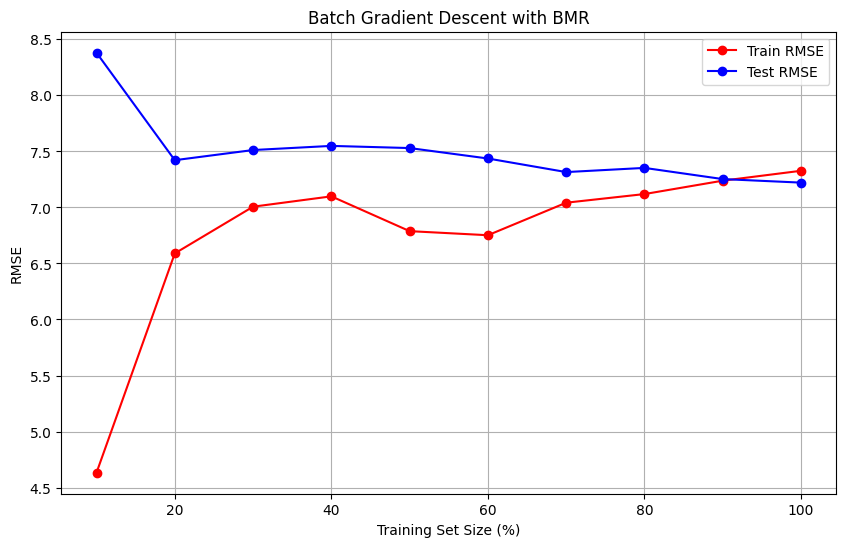

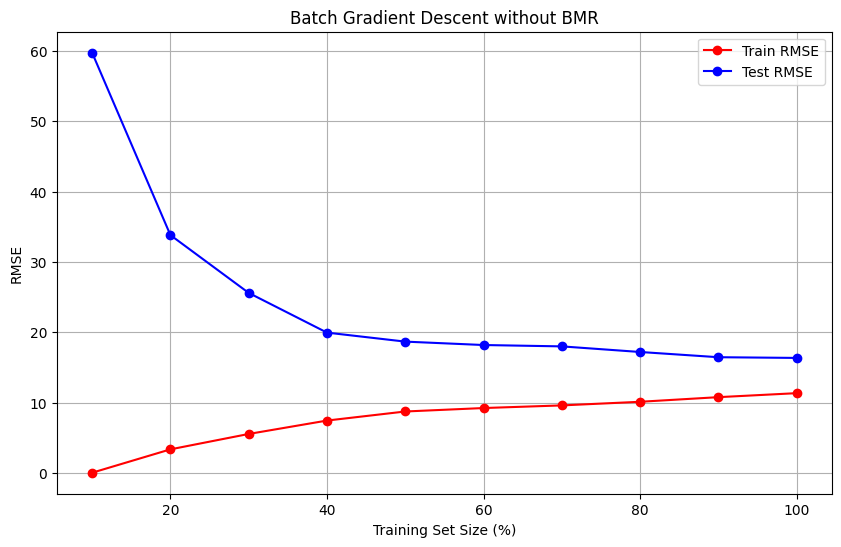

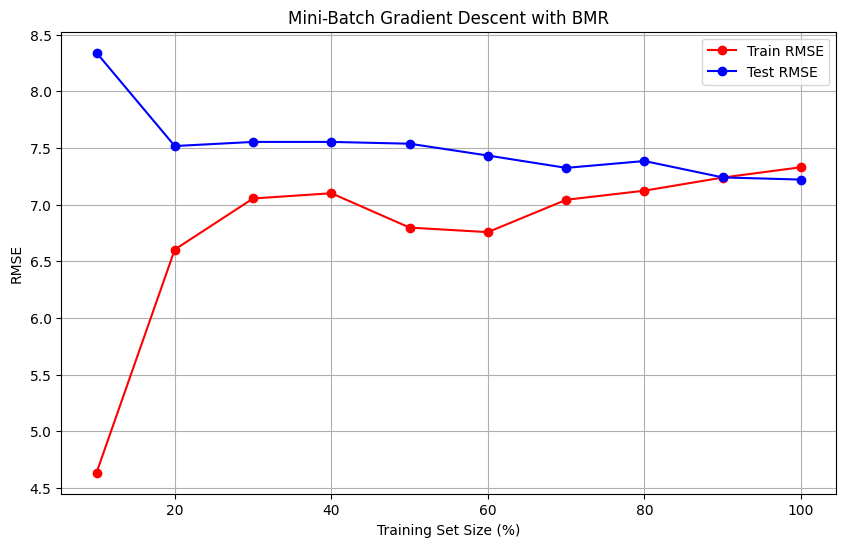

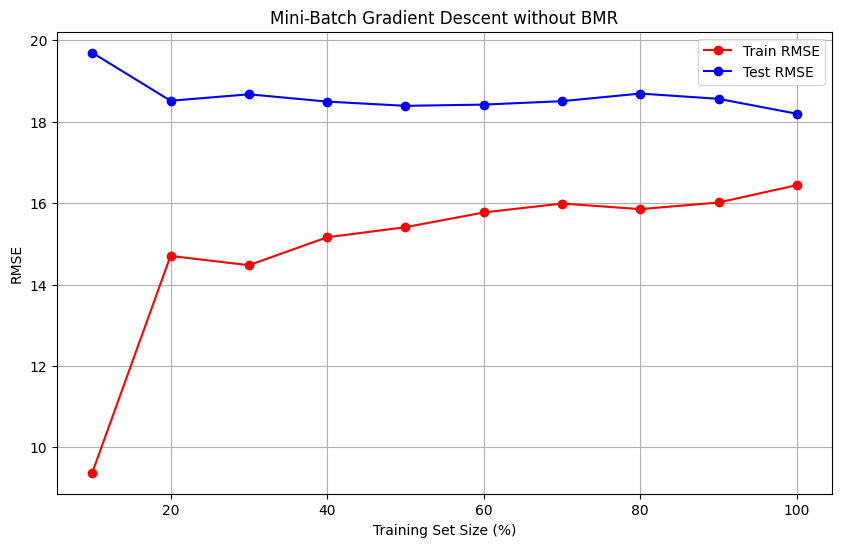

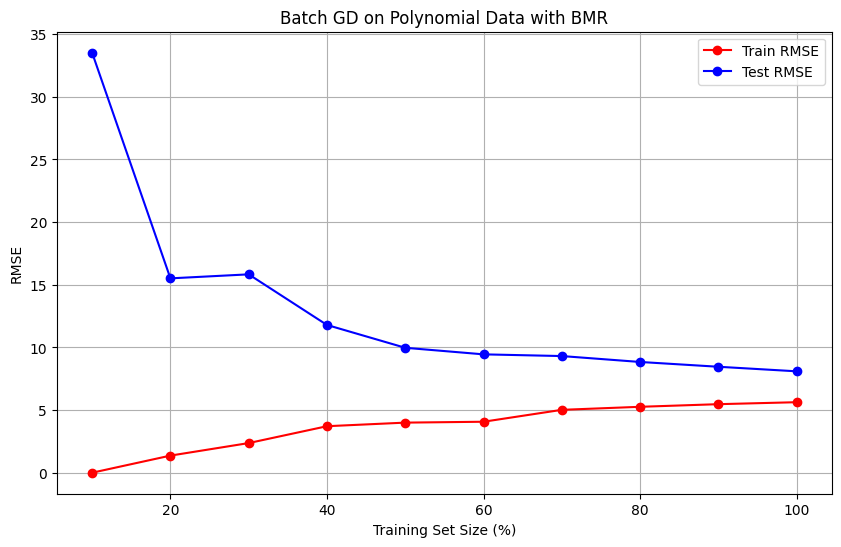

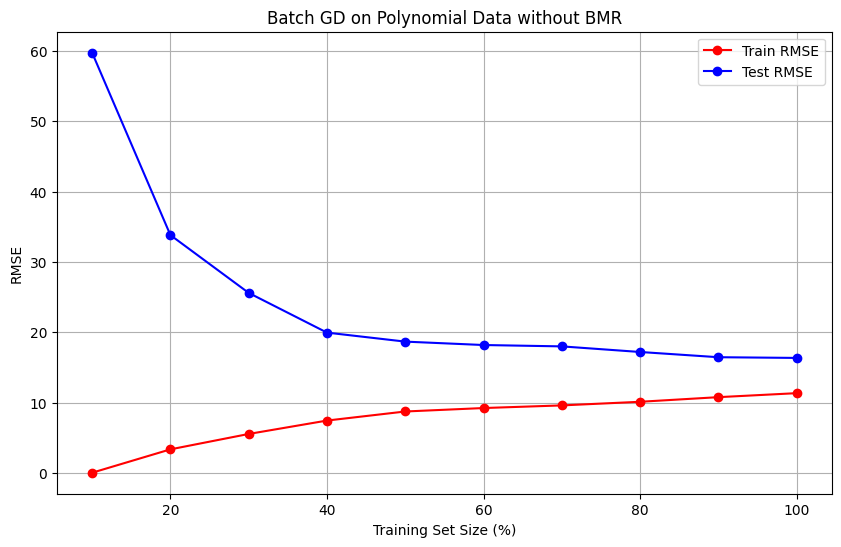

In [61]:
def plot_rmse_vs_training_size(training_sizes, train_rmse, test_rmse, title):
    plt.figure(figsize=(10, 6))
    plt.plot(training_sizes, train_rmse, label='Train RMSE', color='red', marker='o')
    plt.plot(training_sizes, test_rmse, label='Test RMSE', color='blue', marker='o')
    plt.xlabel('Training Set Size (%)')
    plt.ylabel('RMSE')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage for Batch Gradient Descent with BMR
plot_rmse_vs_training_size(training_sizes_bmr, train_rmse_bmr, test_rmse_bmr, 'Batch Gradient Descent with BMR')

# Example usage for Batch Gradient Descent without BMR
plot_rmse_vs_training_size(training_sizes_without_bmr, train_rmse_without_bmr, test_rmse_without_bmr, 'Batch Gradient Descent without BMR')

# Example usage for Mini-Batch Gradient Descent with BMR
plot_rmse_vs_training_size(training_sizes_mini_bmr, train_rmse_mini_bmr, test_rmse_mini_bmr, 'Mini-Batch Gradient Descent with BMR')

# Example usage for Mini-Batch Gradient Descent without BMR
plot_rmse_vs_training_size(training_sizes_mini_without_bmr, train_rmse_mini_without_bmr, test_rmse_mini_without_bmr, 'Mini-Batch Gradient Descent without BMR')

plot_rmse_vs_training_size(training_sizes_with_bmr, train_rmse_with_bmr, test_rmse_with_bmr, 'Batch GD on Polynomial Data with BMR')

plot_rmse_vs_training_size(training_sizes_without_bmr, train_rmse_without_bmr, test_rmse_without_bmr, 'Batch GD on Polynomial Data without BMR')

With BMR (First Plot)

In the model with BMR, train and test RMSE values remain close as the training set size increases. This indicates a good balance with minimal overfitting, as both the train and test errors stabilize around similar values. The consistent RMSE across different training set sizes suggests the model generalizes well and captures the relationship between features effectively.

Without BMR (Second Plot)

In the model without BMR, there is a noticeable gap between train and test RMSE across all training set sizes. The test RMSE is significantly higher, even as the training size increases, indicating that the model struggles to generalize effectively. This gap suggests underfitting, as the model is not capturing the full complexity of the data without the BMR feature, leading to poorer performance on the test set.

With BMR (third Plot)

In the model with BMR, train and test RMSE values are closely aligned across all training set sizes, indicating minimal overfitting. The test RMSE stabilizes around 7.5, while the train RMSE remains slightly lower, showing that the model generalizes well. The consistent performance across various training sizes suggests that BMR enables the model to capture the data patterns effectively without overfitting.

Without BMR (fourth Plot)

In the model without BMR, there is a persistent gap between train and test RMSE values, with the test RMSE remaining high, around 18, and the train RMSE around 16 as the training size increases. This gap suggests underfitting, as the model without BMR struggles to generalize well, resulting in significantly higher error on the test set.

With BMR (fifth Plot)

For the model trained on polynomial data with BMR, both train and test RMSE decrease as the training set size increases, with the test RMSE stabilizing around 5 and train RMSE around 3. This indicates that the model is able to capture the data patterns well without overfitting, as the gap between train and test RMSE remains relatively small and stable. The polynomial augmentation combined with BMR allows the model to generalize effectively.

Without BMR (sixth Plot)

In the model without BMR, train RMSE is consistently lower than test RMSE, with a significant gap between them across all training set sizes. The test RMSE stabilizes around 10, much higher than the train RMSE, which suggests that the model is underfitting. Without BMR, even with polynomial augmentation, the model struggles to capture the complexity of the data, resulting in poorer performance on the test set.

### f. Lasso Regularization

In [62]:
from sklearn.linear_model import Lasso
# Define a range of alpha values to test
alpha_values = np.logspace(-4, 1, 10)  # 10 values from 0.0001 to 10 on a log scale

# Initialize lists to store metrics for each alpha value
train_rmse_list_with_bmr = []
test_rmse_list_with_bmr = []
train_r2_list_with_bmr = []
test_r2_list_with_bmr = []
non_zero_features_with_bmr = []

# Variables to store the best metrics and alpha
best_alpha_with_bmr = None
lasso_best_test_rmse_with_bmr = float('inf')
lasso_best_test_r2_with_bmr = float('-inf')

# Lasso regularization loop for dataset with BMR
for alpha in alpha_values:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train_augmented_with_bmr, y_train)
    
    # Predictions on the training and test sets
    y_train_pred = lasso.predict(X_train_augmented_with_bmr)
    y_test_pred = lasso.predict(X_test_augmented_with_bmr)
    
    # Calculate RMSE and R^2
    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    test_rmse = root_mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Append metrics
    train_rmse_list_with_bmr.append(train_rmse)
    test_rmse_list_with_bmr.append(test_rmse)
    train_r2_list_with_bmr.append(train_r2)
    test_r2_list_with_bmr.append(test_r2)
    non_zero_features_with_bmr.append(np.sum(lasso.coef_ != 0))
    
    # Update the best metrics if the current test RMSE or R^2 is better
    if test_rmse < lasso_best_test_rmse_with_bmr:
        lasso_best_test_rmse_with_bmr = test_rmse
        best_alpha_with_bmr = alpha
    if test_r2 > lasso_best_test_r2_with_bmr:
        lasso_best_test_r2_with_bmr = test_r2

c:\Users\ms\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.806e+03, tolerance: 1.585e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\ms\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.721e+03, tolerance: 1.585e+01
  model = cd_fast.enet_coordinate_descent(


In [63]:
# Print best metrics and alpha
print("With BMR:")
print(f"Best Alpha (for lowest RMSE): {best_alpha_with_bmr}")
print(f"Best Test RMSE: {lasso_best_test_rmse_with_bmr}")
print(f"Best Test R²: {lasso_best_test_r2_with_bmr}")

With BMR:
Best Alpha (for lowest RMSE): 0.21544346900318845
Best Test RMSE: 7.073823044999858
Best Test R²: 0.8968224896439333


the Lasso model with BMR achieves excellent performance, underscoring the importance of BMR as a feature. The high R² and low RMSE demonstrate that BMR’s inclusion allows Lasso to generalize effectively while focusing on the most relevant features, leading to robust predictive power.

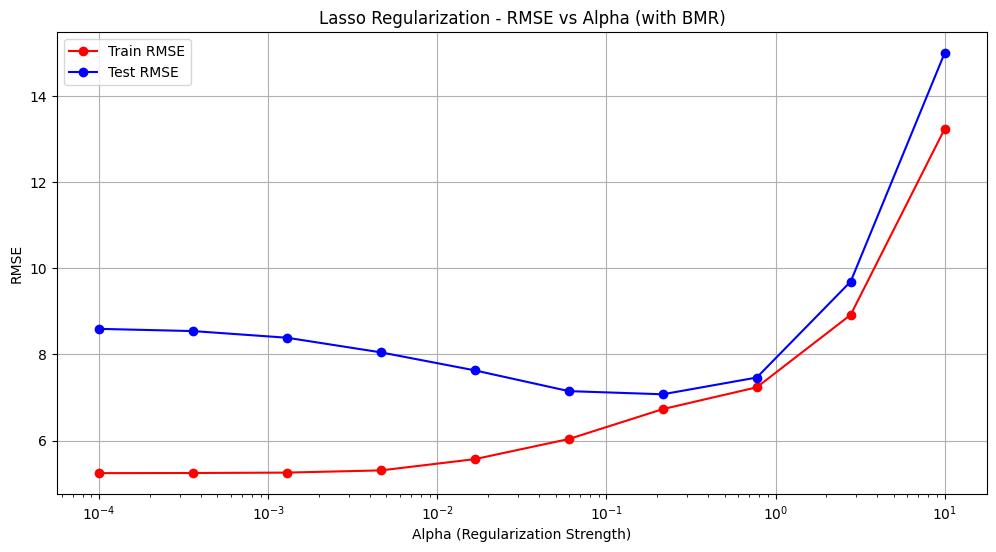

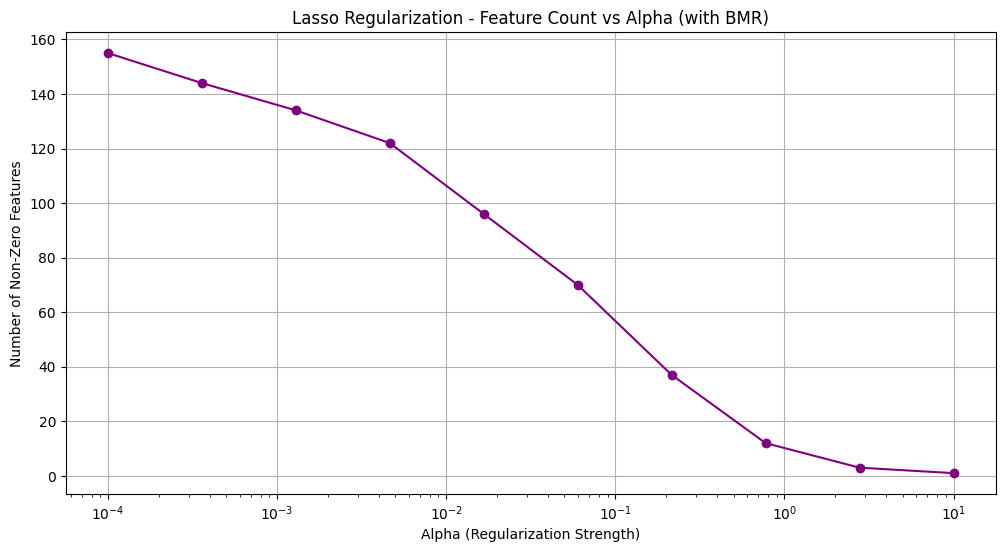

In [64]:
# Plot RMSE vs Alpha for training and test sets (With BMR)
plt.figure(figsize=(12, 6))
plt.plot(alpha_values, train_rmse_list_with_bmr, label="Train RMSE", marker='o', color='red')
plt.plot(alpha_values, test_rmse_list_with_bmr, label="Test RMSE", marker='o', color='blue')
plt.xscale('log')  # Log scale for alpha values
plt.xlabel("Alpha (Regularization Strength)")
plt.ylabel("RMSE")
plt.title("Lasso Regularization - RMSE vs Alpha (with BMR)")
plt.legend()
plt.grid(True)
plt.show()

# Plot Non-Zero Feature Count vs Alpha (With BMR)
plt.figure(figsize=(12, 6))
plt.plot(alpha_values, non_zero_features_with_bmr, marker='o', color='purple')
plt.xscale('log')  # Log scale for alpha values
plt.xlabel("Alpha (Regularization Strength)")
plt.ylabel("Number of Non-Zero Features")
plt.title("Lasso Regularization - Feature Count vs Alpha (with BMR)")
plt.grid(True)
plt.show()

The ideal balance is achieved at moderate alpha values, where the test RMSE is low, and the model selects a manageable number of important features. Low alpha values retain too many features, potentially leading to overfitting, while high alpha values result in underfitting due to excessive regularization and feature elimination.

In [65]:
# Initialize lists to store metrics for each alpha value (without BMR)
train_rmse_list_without_bmr = []
test_rmse_list_without_bmr = []
train_r2_list_without_bmr = []
test_r2_list_without_bmr = []
non_zero_features_without_bmr = []

# Variables to store the best metrics and alpha
best_alpha_without_bmr = None
lasso_best_test_rmse_without_bmr = float('inf')
lasso_best_test_r2_without_bmr = float('-inf')

# Lasso regularization loop for dataset without BMR
for alpha in alpha_values:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train_augmented_without_bmr, y_train)
    
    # Predictions on the training and test sets
    y_train_pred = lasso.predict(X_train_augmented_without_bmr)
    y_test_pred = lasso.predict(X_test_augmented_without_bmr)
    
    # Calculate RMSE and R^2
    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    test_rmse = root_mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Append metrics
    train_rmse_list_without_bmr.append(train_rmse)
    test_rmse_list_without_bmr.append(test_rmse)
    train_r2_list_without_bmr.append(train_r2)
    test_r2_list_without_bmr.append(test_r2)
    non_zero_features_without_bmr.append(np.sum(lasso.coef_ != 0))
    
    # Update the best metrics if the current test RMSE or R^2 is better
    if test_rmse < lasso_best_test_rmse_without_bmr:
        lasso_best_test_rmse_without_bmr = test_rmse
        best_alpha_without_bmr = alpha
    if test_r2 > lasso_best_test_r2_without_bmr:
        lasso_best_test_r2_without_bmr = test_r2


c:\Users\ms\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.964e+03, tolerance: 1.585e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\ms\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.344e+03, tolerance: 1.585e+01
  model = cd_fast.enet_coordinate_descent(


In [66]:
# Print best metrics and alpha
print("Without BMR:")
print(f"Best Alpha (for lowest RMSE): {best_alpha_without_bmr}")
print(f"Best Test RMSE: {lasso_best_test_rmse_without_bmr}")
print(f"Best Test R²: {lasso_best_test_r2_without_bmr}")

Without BMR:
Best Alpha (for lowest RMSE): 0.016681005372000592
Best Test RMSE: 13.08880225676915
Best Test R²: 0.6467546332720681


Lasso's ability to perform feature selection allowed it to achieve relatively high performance on the dataset without BMR, identifying and focusing on the most influential features. This adaptive selection likely helped reduce noise, boosting accuracy and R² compared to other models without BMR. However, the performance is still limited compared to models that include BMR, emphasizing the importance of this feature in maximizing predictive power.

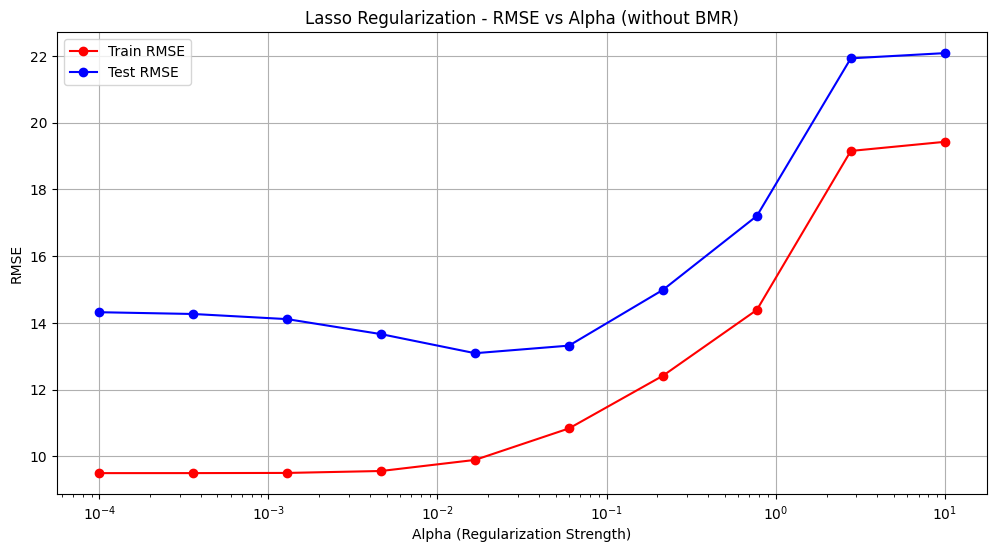

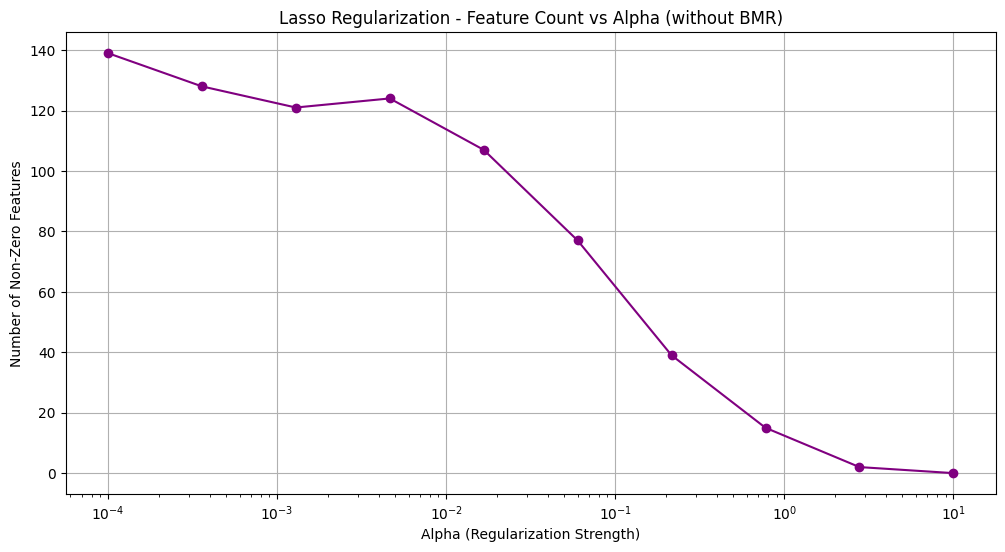

In [67]:
# Plot RMSE vs Alpha for training and test sets (Without BMR)
plt.figure(figsize=(12, 6))
plt.plot(alpha_values, train_rmse_list_without_bmr, label="Train RMSE", marker='o', color='red')
plt.plot(alpha_values, test_rmse_list_without_bmr, label="Test RMSE", marker='o', color='blue')
plt.xscale('log')  # Log scale for alpha values
plt.xlabel("Alpha (Regularization Strength)")
plt.ylabel("RMSE")
plt.title("Lasso Regularization - RMSE vs Alpha (without BMR)")
plt.legend()
plt.grid(True)
plt.show()

# Plot Non-Zero Feature Count vs Alpha (Without BMR)
plt.figure(figsize=(12, 6))
plt.plot(alpha_values, non_zero_features_without_bmr, marker='o', color='purple')
plt.xscale('log')  # Log scale for alpha values
plt.xlabel("Alpha (Regularization Strength)")
plt.ylabel("Number of Non-Zero Features")
plt.title("Lasso Regularization - Feature Count vs Alpha (without BMR)")
plt.grid(True)
plt.show()


Without BMR, the model has higher test RMSE at all alpha levels and does not achieve the same balance as the model with BMR. This highlights BMR’s importance in stabilizing performance and enabling effective feature selection. Here, low alpha values lead to overfitting, while high values cause underfitting, but no optimal alpha effectively balances these issues.

### g. Ridge Regression

In [68]:
from sklearn.linear_model import Ridge

# Define alpha values to test for Ridge regression
alpha_values = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10]

# Initialize lists to store metrics for each alpha value
train_rmse_list_with_bmr = []
test_rmse_list_with_bmr = []
train_r2_list_with_bmr = []
test_r2_list_with_bmr = []

# Variables to store the best metrics and alpha
best_alpha_with_bmr = None
ridge_best_test_rmse_with_bmr = float('inf')
ridge_best_test_r2_with_bmr = float('-inf')

# Ridge regularization loop for dataset with BMR
for alpha in alpha_values:
    ridge = Ridge(alpha=alpha, max_iter=10000)
    ridge.fit(X_train_augmented_with_bmr, y_train)
    
    # Predictions on the training and test sets
    y_train_pred = ridge.predict(X_train_augmented_with_bmr)
    y_test_pred = ridge.predict(X_test_augmented_with_bmr)
    
    # Calculate RMSE and R^2
    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    test_rmse = root_mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Append metrics
    train_rmse_list_with_bmr.append(train_rmse)
    test_rmse_list_with_bmr.append(test_rmse)
    train_r2_list_with_bmr.append(train_r2)
    test_r2_list_with_bmr.append(test_r2)
    
    # Update the best metrics if the current test RMSE or R^2 is better
    if test_rmse < ridge_best_test_rmse_with_bmr:
        ridge_best_test_rmse_with_bmr = test_rmse
        best_alpha_with_bmr = alpha
    if test_r2 > ridge_best_test_r2_with_bmr:
        ridge_best_test_r2_with_bmr = test_r2

In [69]:
# Print best metrics and alpha
print("With BMR:")
print(f"Best Alpha (for lowest RMSE): {best_alpha_with_bmr}")
print(f"Best Test RMSE: {ridge_best_test_rmse_with_bmr}")
print(f"Best Test R²: {ridge_best_test_r2_with_bmr}")

With BMR:
Best Alpha (for lowest RMSE): 10
Best Test RMSE: 7.438421576814826
Best Test R²: 0.885912454061347


RMSE and R^2 in line with the other models

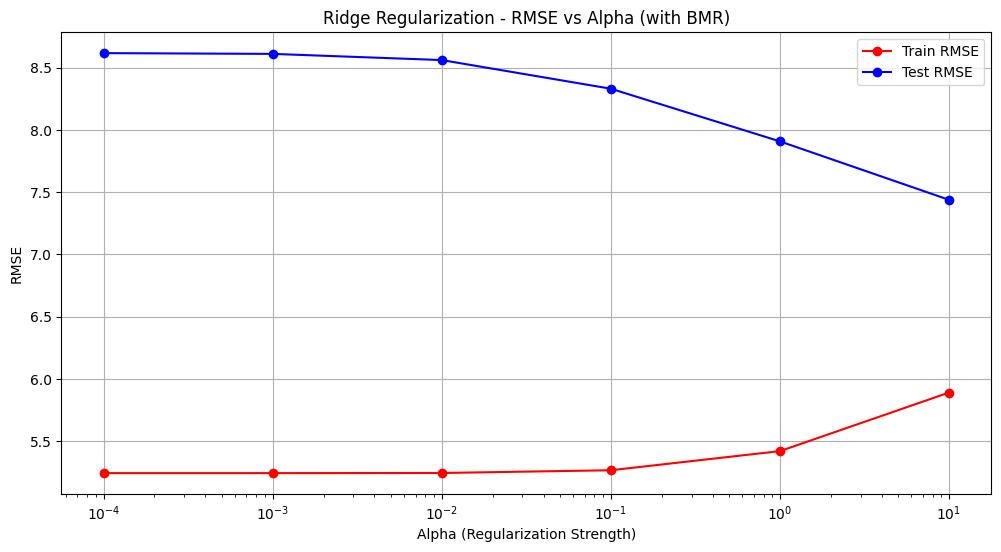

In [70]:
# Plot RMSE vs Alpha for training and test sets (With BMR)
plt.figure(figsize=(12, 6))
plt.plot(alpha_values, train_rmse_list_with_bmr, label="Train RMSE", marker='o', color='red')
plt.plot(alpha_values, test_rmse_list_with_bmr, label="Test RMSE", marker='o', color='blue')
plt.xscale('log')  # Log scale for alpha values
plt.xlabel("Alpha (Regularization Strength)")
plt.ylabel("RMSE")
plt.title("Ridge Regularization - RMSE vs Alpha (with BMR)")
plt.legend()
plt.grid(True)
plt.show()


In contrast to Lasso, Ridge regularization with BMR results in improved generalization at higher alpha values without a significant increase in test RMSE. Moderate to high alpha values provide the best balance, reducing overfitting while keeping the model’s predictive power robust on the test set. This stability in RMSE, particularly in the test set, shows Ridge’s effectiveness in controlling complexity while maintaining model performance.

In [71]:
# Initialize lists to store metrics for each alpha value (without BMR)
train_rmse_list_without_bmr = []
test_rmse_list_without_bmr = []
train_r2_list_without_bmr = []
test_r2_list_without_bmr = []

# Variables to store the best metrics and alpha
best_alpha_without_bmr = None
ridge_best_test_rmse_without_bmr = float('inf')
ridge_best_test_r2_without_bmr = float('-inf')

# Ridge regularization loop for dataset without BMR
for alpha in alpha_values:
    ridge = Ridge(alpha=alpha, max_iter=10000)
    ridge.fit(X_train_augmented_without_bmr, y_train)
    
    # Predictions on the training and test sets
    y_train_pred = ridge.predict(X_train_augmented_without_bmr)
    y_test_pred = ridge.predict(X_test_augmented_without_bmr)
    
    # Calculate RMSE and R^2
    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    test_rmse = root_mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Append metrics
    train_rmse_list_without_bmr.append(train_rmse)
    test_rmse_list_without_bmr.append(test_rmse)
    train_r2_list_without_bmr.append(train_r2)
    test_r2_list_without_bmr.append(test_r2)
    
    # Update the best metrics if the current test RMSE or R^2 is better
    if test_rmse < ridge_best_test_rmse_without_bmr:
        ridge_best_test_rmse_without_bmr = test_rmse
        best_alpha_without_bmr = alpha
    if test_r2 > ridge_best_test_r2_without_bmr:
        ridge_best_test_r2_without_bmr = test_r2


In [72]:
# Print best metrics and alpha
print("Without BMR:")
print(f"Best Alpha (for lowest RMSE): {best_alpha_without_bmr}")
print(f"Best Test RMSE: {ridge_best_test_rmse_without_bmr}")
print(f"Best Test R²: {ridge_best_test_r2_without_bmr}")

Without BMR:
Best Alpha (for lowest RMSE): 0.1
Best Test RMSE: 13.999224248140191
Best Test R²: 0.5959039530811434


Ridge regression without BMR performs slightly better than other models without BMR due to Ridge’s unique ability to control the model’s complexity by penalizing large coefficients. 

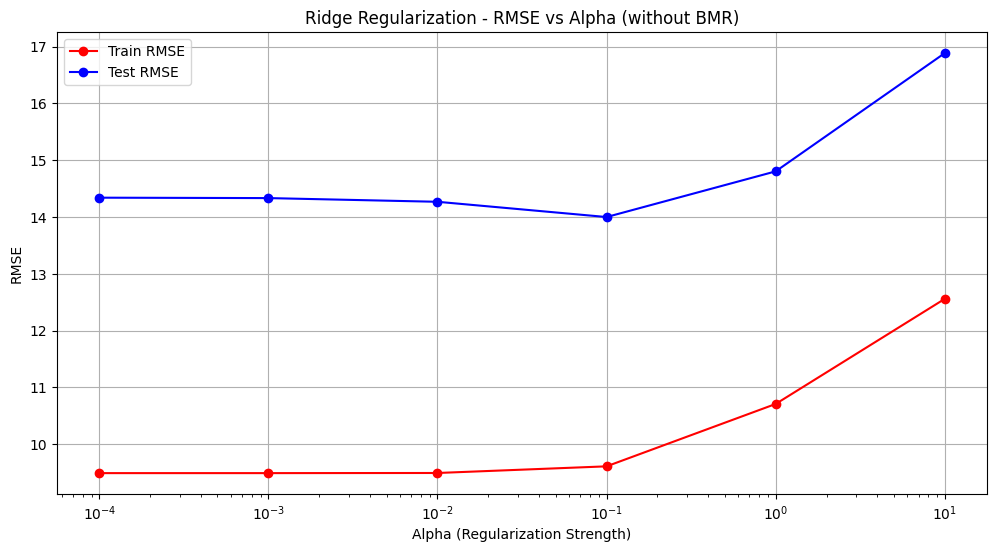

In [73]:
# Plot RMSE vs Alpha for training and test sets (Without BMR)
plt.figure(figsize=(12, 6))
plt.plot(alpha_values, train_rmse_list_without_bmr, label="Train RMSE", marker='o', color='red')
plt.plot(alpha_values, test_rmse_list_without_bmr, label="Test RMSE", marker='o', color='blue')
plt.xscale('log')  # Log scale for alpha values
plt.xlabel("Alpha (Regularization Strength)")
plt.ylabel("RMSE")
plt.title("Ridge Regularization - RMSE vs Alpha (without BMR)")
plt.legend()
plt.grid(True)
plt.show()


The model without BMR performs consistently worse across all alpha levels, as indicated by higher test RMSE values and a lack of improvement in generalization with regularization. Including BMR allows Ridge regularization to control complexity more effectively, providing a better balance between train and test performance across alpha values.

# Gender-Stratified Linear Regression Models
   - Using `dataset_reduced`, create two separate linear regression models for predicting the Final Weight (lbs) by gender (one model for male and one for female participants).
   - Optimize the number of iterations and learning rate \( \eta \) for each model, and plot the learning curves for comparison.


In [74]:
# Reset indexes to ensure alignment
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
dataset_reduced_combined = dataset_reduced_combined.reset_index(drop=True)
dataset_reduced_test_combined = dataset_reduced_test_combined.reset_index(drop=True)


In [75]:
# Add gender columns
dataset_reduced_combined['Gender_M'] = X_train['Gender_M']
dataset_reduced_combined['Gender_F'] = X_train['Gender_F']
dataset_reduced_test_combined['Gender_M'] = X_test['Gender_M']
dataset_reduced_test_combined['Gender_F'] = X_test['Gender_F']


In [76]:
# Male and female feature sets with preserved indices
X_train_male = dataset_reduced_combined[dataset_reduced_combined['Gender_M'] == 1].drop(columns=['Gender_M', 'Gender_F'])
X_train_female = dataset_reduced_combined[dataset_reduced_combined['Gender_F'] == 1].drop(columns=['Gender_M', 'Gender_F'])

X_test_male = dataset_reduced_test_combined[dataset_reduced_test_combined['Gender_M'] == 1].drop(columns=['Gender_M', 'Gender_F'])
X_test_female = dataset_reduced_test_combined[dataset_reduced_test_combined['Gender_F'] == 1].drop(columns=['Gender_M', 'Gender_F'])

# Extract corresponding target values by index for alignment
y_train_male = y_train.loc[X_train_male.index]
y_train_female = y_train.loc[X_train_female.index]

y_test_male = y_test.loc[X_test_male.index]
y_test_female = y_test.loc[X_test_female.index]

# Male and Female without BMR feature
X_train_male_without_bmr = X_train_male.drop(columns=['BMR (Calories)'], errors='ignore').values
X_test_male_without_bmr = X_test_male.drop(columns=['BMR (Calories)'], errors='ignore').values

X_train_female_without_bmr = X_train_female.drop(columns=['BMR (Calories)'], errors='ignore').values
X_test_female_without_bmr = X_test_female.drop(columns=['BMR (Calories)'], errors='ignore').values



In [77]:
# Shape verification for gender-stratified datasets
print("Gender-Stratified Dataset Shapes Verification:")
print(f"X_train_male shape: {X_train_male.shape}")
print(f"y_train_male shape: {y_train_male.shape}")
print(f"X_train_female shape: {X_train_female.shape}")
print(f"y_train_female shape: {y_train_female.shape}")
print(f"X_test_male shape: {X_test_male.shape}")
print(f"y_test_male shape: {y_test_male.shape}")
print(f"X_test_female shape: {X_test_female.shape}")
print(f"y_test_female shape: {y_test_female.shape}")
print(f"X_train_male_without_bmr shape:{X_train_male_without_bmr.shape}")
print(f"X_train_female_without_bmr shape:{X_train_female_without_bmr.shape}")


Gender-Stratified Dataset Shapes Verification:
X_train_male shape: (186, 9)
y_train_male shape: (186,)
X_train_female shape: (190, 9)
y_train_female shape: (190,)
X_test_male shape: (89, 9)
y_test_male shape: (89,)
X_test_female shape: (75, 9)
y_test_female shape: (75,)
X_train_male_without_bmr shape:(186, 8)
X_train_female_without_bmr shape:(190, 8)


In [78]:
import numpy as np

def train_gender_specific_model(X_train, y_train, eta, n_iterations=100):
    # Number of training examples
    m = X_train.shape[0]
    
    # Add intercept column (1s) to X_train
    X_b = np.c_[np.ones((m, 1)), X_train]  # Adds intercept term
    
    # Initialize theta randomly
    theta = np.random.randn(X_b.shape[1])
    
    # Initialize list to store MSE for each iteration
    learning_curve = []
    
    # Gradient Descent Loop
    for iteration in range(n_iterations):
        # Compute predictions
        y_pred = X_b.dot(theta)
        
        # Compute gradient of MSE
        gradients = (2 / m) * X_b.T.dot(y_pred - y_train)
        
        # Update theta
        theta -= eta * gradients
        
        # Calculate and store current MSE for learning curve
        mse = (1 / m) * np.sum((y_pred - y_train) ** 2)
        learning_curve.append(mse)
    
    return theta, learning_curve

In [79]:
# Convert DataFrames to numpy arrays if necessary
X_train_male_np = X_train_male.values
y_train_male_np = y_train_male.values
X_train_female_np = X_train_female.values
y_train_female_np = y_train_female.values

# Set custom hyperparameters
eta_male = 0.03
eta_female = 0.03
n_iterations_male = 100
n_iterations_female = 100

# Train models for each gender
theta_male, learning_curve_male = train_gender_specific_model(X_train_male_np, y_train_male_np, eta=eta_male, n_iterations=n_iterations_male)
theta_female, learning_curve_female = train_gender_specific_model(X_train_female_np, y_train_female_np, eta=eta_female, n_iterations=n_iterations_female)


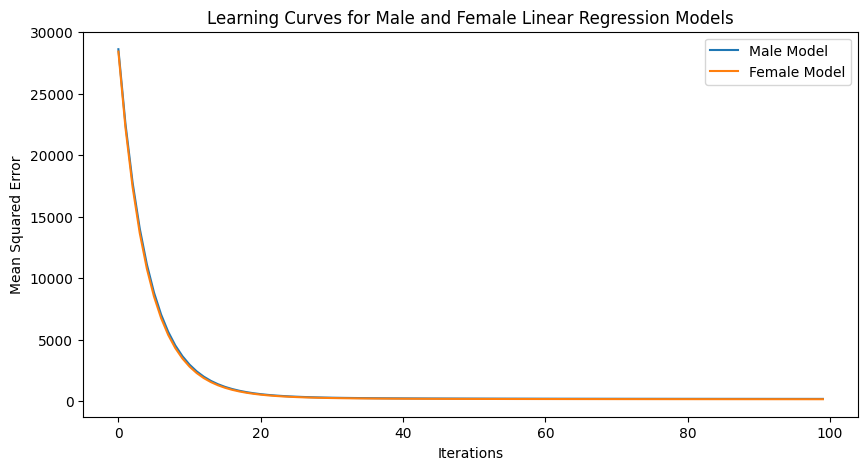

In [80]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(learning_curve_male, label='Male Model')
plt.plot(learning_curve_female, label='Female Model')
plt.xlabel('Iterations')
plt.ylabel('Mean Squared Error')
plt.title('Learning Curves for Male and Female Linear Regression Models')
plt.legend()
plt.show()


- Rapid Convergence: Both male and female models quickly reduce MSE, stabilizing near zero by 20 iterations, indicating effective learning.
- Similar Performance: The nearly identical curves suggest that features predict equally well for both genders.
- Low Final MSE: The final MSE close to zero implies high accuracy, though further checks are needed to ensure no overfitting.
- Both models perform similarly, learning efficiently and achieving low error across genders


Testing eta = 0.005 for Male Model

Testing eta = 0.005 for Female Model

Testing eta = 0.01 for Male Model

Testing eta = 0.01 for Female Model

Testing eta = 0.02 for Male Model

Testing eta = 0.02 for Female Model

Testing eta = 0.03 for Male Model

Testing eta = 0.03 for Female Model


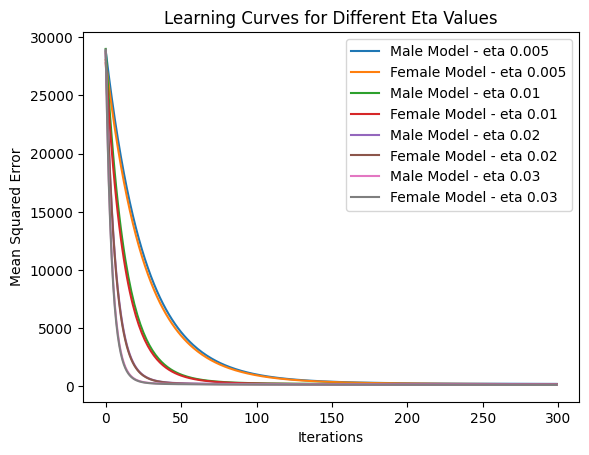

In [81]:
# Experiment with different values of eta
eta_values = [0.005, 0.01, 0.02, 0.03]  # Test a range of learning rates
n_iterations = 300  # Reduced iterations since the models converge quickly

for eta in eta_values:
    print(f"\nTesting eta = {eta} for Male Model")
    theta_male, learning_curve_male = train_gender_specific_model(X_train_male_np, y_train_male_np, eta=eta, n_iterations=n_iterations)
    plt.plot(learning_curve_male, label=f'Male Model - eta {eta}')
    
    print(f"\nTesting eta = {eta} for Female Model")
    theta_female, learning_curve_female = train_gender_specific_model(X_train_female_np, y_train_female_np, eta=eta, n_iterations=n_iterations)
    plt.plot(learning_curve_female, label=f'Female Model - eta {eta}')

# Plot all learning curves for comparison
plt.xlabel('Iterations')
plt.ylabel('Mean Squared Error')
plt.title('Learning Curves for Different Eta Values')
plt.legend()
plt.show()


- Faster Convergence with Higher Eta: Models with higher learning rates (eta) converge more quickly, achieving low Mean Squared Error (MSE) in fewer iterations.
- Lowest MSE for Eta 0.03: The eta value of 0.03 shows the best performance, with the quickest drop in MSE for both male and female models.
- Smooth Decline Across All Models: Regardless of eta, all models show a smooth and steady decline in MSE, indicating stable learning.

Conclusion: An eta of 0.03 provides the fastest and most efficient learning, suggesting it’s the optimal rate for these models.

In [82]:
# Define a list of eta
eta_values = [0.001, 0.005, 0.01, 0.02, 0.03, 0.05]
n_iterations = 500

metrics = {
    'Male_with_bmr': {},
    'Male_without_bmr': {},
    'Female_with_bmr': {},
    'Female_without_bmr': {}
}

def calculate_best_eta_and_metrics(X_train, y_train, X_test, y_test, eta_values, n_iterations, model_key):
    best_eta = None
    best_rmse = float('inf')
    best_theta = None
    
    for eta in eta_values:
        theta, _ = train_gender_specific_model(X_train, y_train, eta=eta, n_iterations=n_iterations)
        
        # Calculates predictions and RMSE on the test set

        X_b_test = np.c_[np.ones((X_test.shape[0], 1)), X_test]
        y_pred_test = X_b_test.dot(theta)
        rmse = np.sqrt(np.mean((y_test - y_pred_test) ** 2))
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_eta = eta
            best_theta = theta

    #  Calculate final RMSE and R^2 for the best model
    X_b_test = np.c_[np.ones((X_test.shape[0], 1)), X_test]
    y_pred_test = X_b_test.dot(best_theta)
    final_rmse = np.sqrt(np.mean((y_test - y_pred_test) ** 2))
    final_r2 = r2_score(y_test, y_pred_test)
    
    # create a dictionary
    metrics[model_key] = {
        'Best_eta': best_eta,
        'Final_RMSE': final_rmse,
        'Final_R2': final_r2,
        'Theta': best_theta
    }

In [83]:
# male with BMR
calculate_best_eta_and_metrics(
    X_train=X_train_male.values, 
    y_train=y_train_male.values, 
    X_test=X_test_male.values, 
    y_test=y_test_male.values, 
    eta_values=eta_values, 
    n_iterations=n_iterations, 
    model_key='Male_with_bmr'
)

# Male without BMR
calculate_best_eta_and_metrics(
    X_train=X_train_male_without_bmr, 
    y_train=y_train_male.values, 
    X_test=X_test_male_without_bmr, 
    y_test=y_test_male.values, 
    eta_values=eta_values, 
    n_iterations=n_iterations, 
    model_key='Male_without_bmr'
)

In [84]:
# female with BMR
calculate_best_eta_and_metrics(
    X_train=X_train_female.values, 
    y_train=y_train_female.values, 
    X_test=X_test_female.values, 
    y_test=y_test_female.values, 
    eta_values=eta_values, 
    n_iterations=n_iterations, 
    model_key='Female_with_bmr'
)

# female without BMR
calculate_best_eta_and_metrics(
    X_train=X_train_female_without_bmr, 
    y_train=y_train_female.values, 
    X_test=X_test_female_without_bmr, 
    y_test=y_test_female.values, 
    eta_values=eta_values, 
    n_iterations=n_iterations, 
    model_key='Female_without_bmr'
)

In [85]:
# Step 4: print results
for model, model_metrics in metrics.items():
    print(f"\nMetrics for {model}:")
    print(f"  Best Eta: {model_metrics['Best_eta']}")
    print(f"  Final RMSE: {model_metrics['Final_RMSE']}")
    print(f"  Final R^2: {model_metrics['Final_R2']}")


Metrics for Male_with_bmr:
  Best Eta: 0.05
  Final RMSE: 10.077997498117789
  Final R^2: 0.7972989572641527

Metrics for Male_without_bmr:
  Best Eta: 0.05
  Final RMSE: 22.017699692327145
  Final R^2: 0.03249909878166357

Metrics for Female_with_bmr:
  Best Eta: 0.05
  Final RMSE: 9.131378518714016
  Final R^2: 0.8308170152973008

Metrics for Female_without_bmr:
  Best Eta: 0.05
  Final RMSE: 21.92518549013674
  Final R^2: 0.024627417675789354


even in the case where we have two separate datasets of male and female,  Including BMR drastically improves model accuracy for both genders, with lower RMSE and much higher R² values. The models without BMR struggle to capture variance, resulting in poor predictions and indicating that BMR is essential for accurate weight prediction.

In [86]:
# store the values in variables
# Extrapolates values for the Batch Gradient Descent Male model with BMR
batch_male_with_bmr_rmse = metrics['Male_with_bmr']['Final_RMSE']
batch_male_with_bmr_r2 = metrics['Male_with_bmr']['Final_R2']

# Extrapolates values for the Batch Gradient Descent Female model with BMR
batch_female_with_bmr_rmse = metrics['Female_with_bmr']['Final_RMSE']
batch_female_with_bmr_r2 = metrics['Female_with_bmr']['Final_R2']

# Extrapolates values for the Batch Gradient Descent Male model without BMR
batch_male_without_bmr_rmse = metrics['Male_without_bmr']['Final_RMSE']
batch_male_without_bmr_r2 = metrics['Male_without_bmr']['Final_R2']

# Extrapolates values for the Batch Gradient Descent female model without BMR
batch_female_without_bmr_rmse = metrics['Female_without_bmr']['Final_RMSE']
batch_female_without_bmr_r2 = metrics['Female_without_bmr']['Final_R2']

# Performance Comparison by Gender
   - Compare the performance of the gender-stratified models (from Task 4) with the global approach (from Task 3) on `dataset_reduced`.
   - Assess the models' ability to predict the Final Weight (lbs) for each gender separately on the test set.
   - Visualize and compare the results.

#### global models for each method

In [87]:
### I stored the values RMSE e R^2 of each global model (with and witout BMR) in those variables
# lr_rmse_test_with_bmr_reduced
# lr_r2_test_with_bmr_reduced
# lr_rmse_test_without_bmr_reduce
# lr_r2_test_without_bmr_reduced
# batch_test_rmse_with_bmr
# batch_test_r2_with_bmr
# batch_test_rmse_without_bmr
# batch_test_r2_without_bmr
# mini_batch_test_rmse
# mini_batch_test_r2
# mini_batch_test_rmse_without_bmr
# mini_batch_test_r2_without_bmr

#### models with BMR feature

In [88]:
# Linear Regression model for male
lr_male = LinearRegression()
lr_male.fit(X_train_male, y_train_male)
y_pred_male_test = lr_male.predict(X_test_male)

# Calculate RMSE and R² for the male model
lr_rmse_test_male = root_mean_squared_error(y_test_male, y_pred_male_test)
lr_r2_test_male = r2_score(y_test_male, y_pred_male_test)

# Linear Regression model for females
lr_female = LinearRegression()
lr_female.fit(X_train_female, y_train_female)
y_pred_female_test = lr_female.predict(X_test_female)

# Calculate RMSE and R² for the female model
lr_rmse_test_female = root_mean_squared_error(y_test_female, y_pred_female_test)
lr_r2_test_female = r2_score(y_test_female, y_pred_female_test)

# print results
print(f"Linear Regression - Male Model: RMSE = {lr_rmse_test_male:.4f}, R² = {lr_r2_test_male:.4f}")
print(f"Linear Regression - Female Model: RMSE = {lr_rmse_test_female:.4f}, R² = {lr_r2_test_female:.4f}")

Linear Regression - Male Model: RMSE = 7.7355, R² = 0.8806
Linear Regression - Female Model: RMSE = 6.3882, R² = 0.9172


Both models perform well, but the female model achieves slightly better accuracy, with lower RMSE and higher R², indicating it captures the target variable’s variance more effectively.

In [89]:
#  Mini-Batch Gradient Descent male
theta_male_mini, mini_rmse_train_male, mini_rmse_test_male, _ = mini_batch_gradient_descent(
    X_train_male, y_train_male, X_test_male, y_test_male, 
    learning_rate=best_mini_batch_eta_BMR, batch_size=32, n_iterations=1000
)

# RMSE and R^2 male
y_pred_test_male_mini = np.c_[np.ones((X_test_male.shape[0], 1)), X_test_male].dot(theta_male_mini)
mini_batch_test_rmse_male = root_mean_squared_error(y_test_male, y_pred_test_male_mini)
mini_batch_test_r2_male = r2_score(y_test_male, y_pred_test_male_mini)

#  Mini-Batch Gradient Descent female
theta_female_mini, mini_rmse_train_female, mini_rmse_test_female, _ = mini_batch_gradient_descent(
    X_train_female, y_train_female, X_test_female, y_test_female, 
    learning_rate=best_mini_batch_eta_BMR, batch_size=32, n_iterations=1000
)

# RMSE and R^2 Female
y_pred_test_female_mini = np.c_[np.ones((X_test_female.shape[0], 1)), X_test_female].dot(theta_female_mini)
mini_batch_test_rmse_female = root_mean_squared_error(y_test_female, y_pred_test_female_mini)
mini_batch_test_r2_female = r2_score(y_test_female, y_pred_test_female_mini)

# print results
print(f"Mini-Batch Gradient Descent - Male Model: RMSE = {mini_batch_test_rmse_male:.4f}, R² = {mini_batch_test_r2_male:.4f}")
print(f"Mini-Batch Gradient Descent - Female Model: RMSE = {mini_batch_test_rmse_female:.4f}, R² = {mini_batch_test_r2_female:.4f}")


Mini-Batch Gradient Descent - Male Model: RMSE = 7.7314, R² = 0.8807
Mini-Batch Gradient Descent - Female Model: RMSE = 6.3979, R² = 0.9169


Both models demonstrate strong performance, but the female model is slightly more accurate, evidenced by a lower RMSE and higher R². This suggests the female model captures more variance in the target variable, providing a closer fit to the actual data.

In [90]:
# dictionary
results_gender_specific = {
    'male': {
        'linear_regression': {'rmse': lr_rmse_test_male, 'r2': lr_r2_test_male},
        'mini_batch_gradient': {'rmse': mini_batch_test_rmse_male, 'r2': mini_batch_test_r2_male},
    },
    'female': {
        'linear_regression': {'rmse': lr_rmse_test_female, 'r2': lr_r2_test_female},
        'mini_batch_gradient': {'rmse': mini_batch_test_rmse_female, 'r2': mini_batch_test_r2_female},
    }
}

for gender, metrics in results_gender_specific.items():
    print(f"\nResults for {gender.capitalize()} Model:")
    for model, metric_values in metrics.items():
        print(f"{model.capitalize()}: RMSE = {metric_values['rmse']:.4f}, R² = {metric_values['r2']:.4f}")



Results for Male Model:
Linear_regression: RMSE = 7.7355, R² = 0.8806
Mini_batch_gradient: RMSE = 7.7314, R² = 0.8807

Results for Female Model:
Linear_regression: RMSE = 6.3882, R² = 0.9172
Mini_batch_gradient: RMSE = 6.3979, R² = 0.9169


#### models without BMR features

In [91]:
# Linear Regression male without BMR
lr_male_without_bmr = LinearRegression()
lr_male_without_bmr.fit(X_train_male_without_bmr, y_train_male)
y_pred_male_test_without_bmr = lr_male_without_bmr.predict(X_test_male_without_bmr)

# RMSE and R^2 Male
lr_rmse_test_male_without_bmr = root_mean_squared_error(y_test_male, y_pred_male_test_without_bmr)
lr_r2_test_male_without_bmr = r2_score(y_test_male, y_pred_male_test_without_bmr)

# Linear Regression female without BMR
lr_female_without_bmr = LinearRegression()
lr_female_without_bmr.fit(X_train_female_without_bmr, y_train_female)
y_pred_female_test_without_bmr = lr_female_without_bmr.predict(X_test_female_without_bmr)

# RMSE and R^2 female
lr_rmse_test_female_without_bmr = root_mean_squared_error(y_test_female, y_pred_female_test_without_bmr)
lr_r2_test_female_without_bmr = r2_score(y_test_female, y_pred_female_test_without_bmr)

# print results
print(f"Linear Regression - Male Model without BMR: RMSE = {lr_rmse_test_male_without_bmr:.4f}, R² = {lr_r2_test_male_without_bmr:.4f}")
print(f"Linear Regression - Female Model without BMR: RMSE = {lr_rmse_test_female_without_bmr:.4f}, R² = {lr_r2_test_female_without_bmr:.4f}")


Linear Regression - Male Model without BMR: RMSE = 18.6538, R² = 0.3055
Linear Regression - Female Model without BMR: RMSE = 18.3118, R² = 0.3196


In [92]:
#  Mini-Batch Gradient Descent male without BMR
theta_male_mini_without_bmr, mini_rmse_train_male_without_bmr, mini_rmse_test_male_without_bmr, _ = mini_batch_gradient_descent(
    X_train_male_without_bmr, y_train_male, X_test_male_without_bmr, y_test_male, 
    learning_rate=best_mini_batch_eta_without_bmr, batch_size=32, n_iterations=1000
)

# RMSE and R^2 Male
y_pred_test_male_mini_without_bmr = np.c_[np.ones((X_test_male_without_bmr.shape[0], 1)), X_test_male_without_bmr].dot(theta_male_mini_without_bmr)
mini_batch_test_rmse_male_without_bmr = root_mean_squared_error(y_test_male, y_pred_test_male_mini_without_bmr)
mini_batch_test_r2_male_without_bmr = r2_score(y_test_male, y_pred_test_male_mini_without_bmr)

# Mini-Batch Gradient Descent female without BMR
theta_female_mini_without_bmr, mini_rmse_train_female_without_bmr, mini_rmse_test_female_without_bmr, _ = mini_batch_gradient_descent(
    X_train_female_without_bmr, y_train_female, X_test_female_without_bmr, y_test_female, 
    learning_rate=best_mini_batch_eta_without_bmr, batch_size=32, n_iterations=1000
)

# RMSE and R^2 female
y_pred_test_female_mini_without_bmr = np.c_[np.ones((X_test_female_without_bmr.shape[0], 1)), X_test_female_without_bmr].dot(theta_female_mini_without_bmr)
mini_batch_test_rmse_female_without_bmr = root_mean_squared_error(y_test_female, y_pred_test_female_mini_without_bmr)
mini_batch_test_r2_female_without_bmr = r2_score(y_test_female, y_pred_test_female_mini_without_bmr)

# print results
print(f"Mini-Batch Gradient Descent - Male Model without BMR: RMSE = {mini_batch_test_rmse_male_without_bmr:.4f}, R² = {mini_batch_test_r2_male_without_bmr:.4f}")
print(f"Mini-Batch Gradient Descent - Female Model without BMR: RMSE = {mini_batch_test_rmse_female_without_bmr:.4f}, R² = {mini_batch_test_r2_female_without_bmr:.4f}")


Mini-Batch Gradient Descent - Male Model without BMR: RMSE = 19.4095, R² = 0.2481
Mini-Batch Gradient Descent - Female Model without BMR: RMSE = 19.2599, R² = 0.2474


Without BMR, both models suffer a large drop in accuracy, with higher RMSE and lower R² values. This demonstrates BMR’s importance in accurately predicting the target, as its absence leads to weaker model performance and a substantial reduction in explained variance.

In [93]:
 # dictionary
results_gender_specific_without_bmr = {
    'male': {
        'linear_regression': {'rmse': lr_rmse_test_male_without_bmr, 'r2': lr_r2_test_male_without_bmr},
        'mini_batch_gradient': {'rmse': mini_batch_test_rmse_male_without_bmr, 'r2': mini_batch_test_r2_male_without_bmr},
    },
    'female': {
        'linear_regression': {'rmse': lr_rmse_test_female_without_bmr, 'r2': lr_r2_test_female_without_bmr},
        'mini_batch_gradient': {'rmse': mini_batch_test_rmse_female_without_bmr, 'r2': mini_batch_test_r2_female_without_bmr},
    }
}

# print results
for gender, metrics in results_gender_specific_without_bmr.items():
    print(f"\nResults for {gender.capitalize()} Model without BMR:")
    for model, metric_values in metrics.items():
        print(f"{model.capitalize()}: RMSE = {metric_values['rmse']:.4f}, R² = {metric_values['r2']:.4f}")



Results for Male Model without BMR:
Linear_regression: RMSE = 18.6538, R² = 0.3055
Mini_batch_gradient: RMSE = 19.4095, R² = 0.2481

Results for Female Model without BMR:
Linear_regression: RMSE = 18.3118, R² = 0.3196
Mini_batch_gradient: RMSE = 19.2599, R² = 0.2474


#### Comparision between global models and male/female Models

In [94]:
#dictionary with all the models
comparison_results = {
    'Linear Regression (with BMR)': {
        'Global': {'rmse': lr_rmse_test_with_bmr_reduced, 'r2': lr_r2_test_with_bmr_reduced},
        'Male': {'rmse': lr_rmse_test_male, 'r2': lr_r2_test_male},
        'Female': {'rmse': lr_rmse_test_female, 'r2': lr_r2_test_female},
    },
    'Linear Regression (without BMR)': {
        'Global': {'rmse': lr_rmse_test_without_bmr_reduced, 'r2': lr_r2_test_without_bmr_reduced},
        'Male': {'rmse': lr_rmse_test_male_without_bmr, 'r2': lr_r2_test_male_without_bmr},
        'Female': {'rmse': lr_rmse_test_female_without_bmr, 'r2': lr_r2_test_female_without_bmr},
    },
    'Batch Gradient Descent (with BMR)': {
        'Global': {'rmse': batch_test_rmse_with_bmr, 'r2': batch_test_r2_with_bmr},
        'Male': {'rmse': batch_male_with_bmr_rmse, 'r2': batch_male_with_bmr_r2},
        'Female': {'rmse': batch_female_with_bmr_rmse, 'r2': batch_female_with_bmr_r2},
    },
    'Batch Gradient Descent (without BMR)': {
        'Global': {'rmse': batch_test_rmse_without_bmr, 'r2': batch_test_r2_without_bmr},
        'Male': {'rmse': batch_male_without_bmr_rmse, 'r2': batch_male_without_bmr_r2},
        'Female': {'rmse': batch_female_without_bmr_rmse, 'r2': batch_female_without_bmr_r2},
    },
    'Mini-Batch Gradient Descent (with BMR)': {
        'Global': {'rmse': mini_batch_test_rmse, 'r2': mini_batch_test_r2},
        'Male': {'rmse': mini_batch_test_rmse_male, 'r2': mini_batch_test_r2_male},
        'Female': {'rmse': mini_batch_test_rmse_female, 'r2': mini_batch_test_r2_female},
    },
    'Mini-Batch Gradient Descent (without BMR)': {
        'Global': {'rmse': mini_batch_test_rmse_without_bmr, 'r2': mini_batch_test_r2_without_bmr},
        'Male': {'rmse': mini_batch_test_rmse_male_without_bmr, 'r2': mini_batch_test_r2_male_without_bmr},
        'Female': {'rmse': mini_batch_test_rmse_female_without_bmr, 'r2': mini_batch_test_r2_female_without_bmr},
    }
}


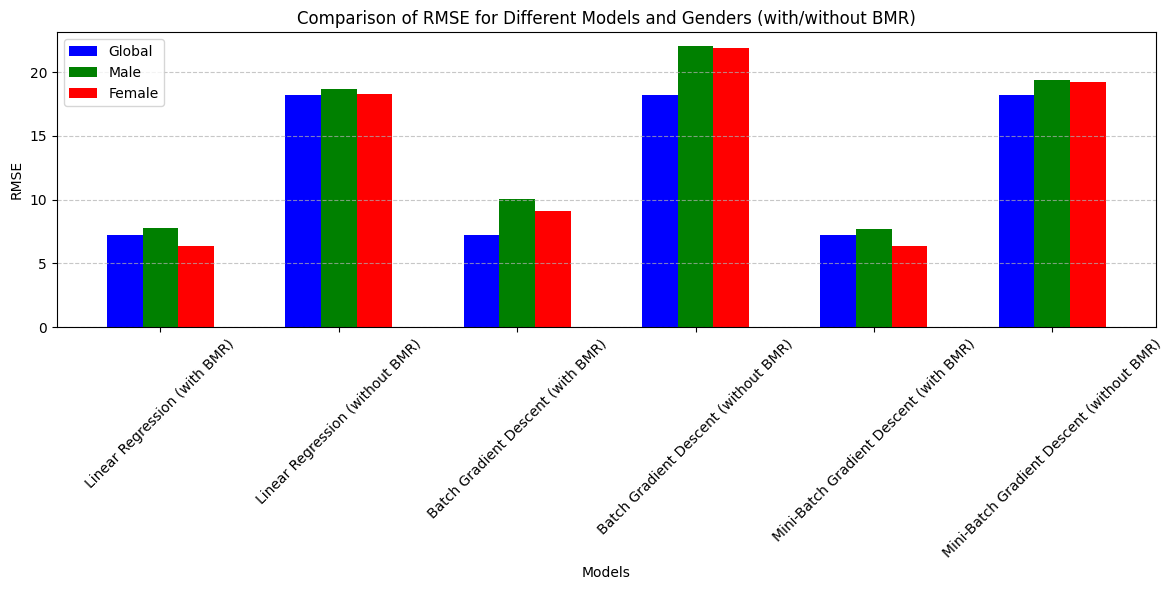

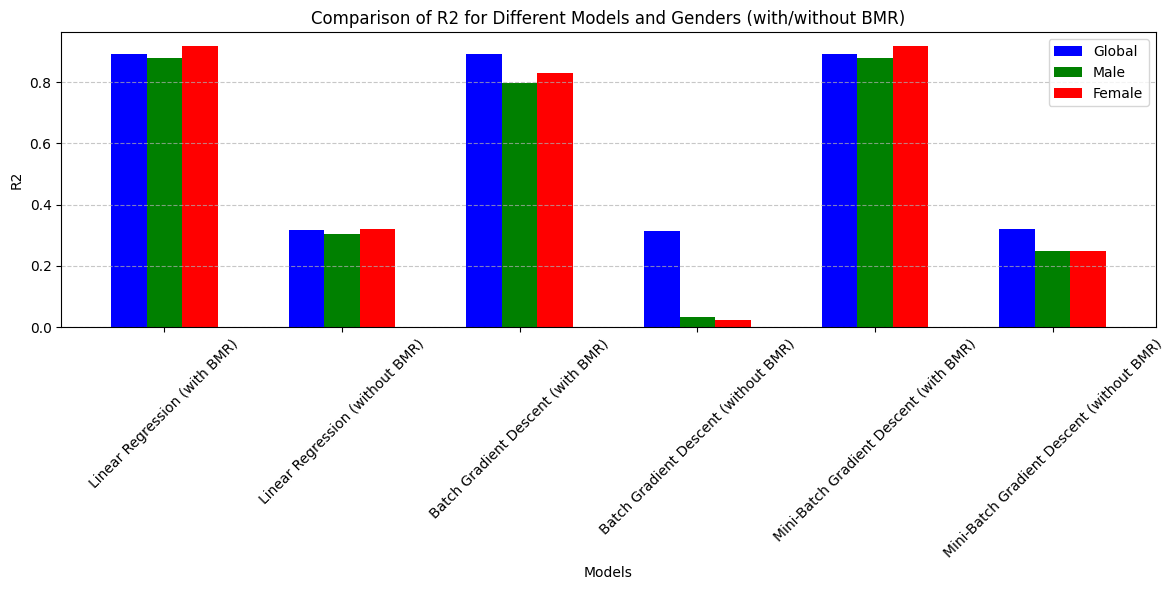

In [95]:
import matplotlib.pyplot as plt

# plot the comparison
def plot_comparison(comparison_results, metric='rmse'):
    labels = list(comparison_results.keys())  # Models: Linear Regression, Batch GD, ecc.
    global_vals = [comparison_results[model]['Global'][metric] for model in labels]
    male_vals = [comparison_results[model]['Male'][metric] for model in labels]
    female_vals = [comparison_results[model]['Female'][metric] for model in labels]

    x = range(len(labels)) 

    plt.figure(figsize=(12, 6))
    width = 0.2 

    # barchart (Global, Male, Female)
    plt.bar(x, global_vals, width=width, label='Global', color='blue', align='center')
    plt.bar([p + width for p in x], male_vals, width=width, label='Male', color='green', align='center')
    plt.bar([p + width*2 for p in x], female_vals, width=width, label='Female', color='red', align='center')

    plt.xlabel('Models')
    plt.ylabel(metric.upper())
    plt.title(f'Comparison of {metric.upper()} for Different Models and Genders (with/without BMR)')
    plt.xticks([p + width for p in x], labels, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Plot RMSE
plot_comparison(comparison_results, metric='rmse')

# Plot R²
plot_comparison(comparison_results, metric='r2')


The two graphs above summarize the performance of various models (Linear Regression, Batch Gradient Descent, and Mini-Batch Gradient Descent) across male, female, and global datasets, with and without the inclusion of the BMR feature.

- BMR Impact: Including BMR cuts RMSE nearly in half and greatly increases R^2, highlighting its importance.
- Top Model: Linear Regression with BMR shows the best performance, with the lowest RMSE and highest R^2, especially for females.
-  Batch Gradient Descent: Performs well with BMR but slightly worse than Linear Regression.
- Linear Regression female and mini-Batch Gradient Descent female and male are the best models
- Batch Gradient Descent without BMR feature is the worst model

The inclusion of BMR is essential for accurate and reliable predictions across all models and datasets. Linear Regression with BMR consistently outperforms other methods, with the lowest RMSE and highest R^2, making it the most effective model in this context. Gradient Descent models also benefit from BMR but show slightly lower performance metrics, indicating they may require further tuning or may not be as well-suited for this particular dataset.

# Final Discussion
   - Provide a final discussion on the results obtained from the tasks above.

the final discussion is elaborated in the report attached to the project